Este trabajo tiene como objetivo predecir la fuga de clientes de una compañía telefónica antes de que ocurra, permitiendo así implementar estrategias de retención. Para ello, utilizamos modelos interpretables que permitan conocer el impacto de cada variable en la decisión de abandono. A partir del archivo histórico FugaClientes_training.csv, analizaremos cuántos clientes se fugarán y quiénes son los más propensos a hacerlo.

Somos el equipo Xonas compuesto por: 
- Juan Pablo Carbonell
- Gemma Pachacama
- Alida Rondon
- Manuel Sanchez
- Lorena Serrano
- Celia Villaverde


# **1. LECTURA E INSPECCIÓN DE DATOS**


El presente archivo de FugaClientes_training.csv muestra la información histórica de su base de clientes que contiene características de los mismos junto con la información de abandono/fuga. Donde la variable Fuga es nuestra variable objetivo.

In [1]:
import feature_engine.imputation as fe_imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import plotly.express as px
import re
import seaborn as sns
import sklearn.impute as skl_imp
import sklearn.metrics as metrics
import sklearn.model_selection as train_test_split
import sklearn.preprocessing as skl_pre
import statsmodels.api as sm
import statsmodels.formula.api as ols
import statsmodels.formula.api as smf
import statsmodels.graphics.mosaicplot as mosaic
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from NuestrasFunciones import *
from relativeImp import relativeImp
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import logit


## **1.1 PRELIMINARES**

In [2]:
Fuga = pd.read_csv(r'FugaClientes_Training.csv')
Fuga.head()

,ID,Genero,Mayor65,Conyuge,PersCargo,Antig.fc.edad,Telf_serv,VariasLineas,Int_serv,Seguridad,...,Antivirus_disp,Soporte_tecnico,TV_streaming,Peliculas,Contrato,Fact_sinPapel,MetodoPago,FacturaMes,FacturaTotal,Fuga
0,7590-VHVEG,Female,0.0,Yes,No,1.0,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,NaN,NaN,29.85,0
1,5575-GNVDE,Male,0.0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,NaN,1889.50,0
2,3668-QPYBK,Male,0.0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,NaN,0.0,No,No,45.0,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,NaN,42.30,1840.75,0
4,9237-HQITU,Female,0.0,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [3]:
Fuga.rename(columns={'Antig.fc.edad':'Antiguedad'}, inplace=True)

to_factor = list(Fuga.loc[:,Fuga.nunique() <= 10])

Fuga[to_factor] = Fuga[to_factor].astype('category')

Fuga.info()

Fuga_categoricas = Fuga.select_dtypes(exclude=['float', 'int', 'object'])

for i, columna in enumerate(Fuga_categoricas.columns):
    print(i, Fuga_categoricas[columna].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6353 entries, 0 to 6352
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID               6353 non-null   object  
 1   Genero           6001 non-null   category
 2   Mayor65          6001 non-null   category
 3   Conyuge          6353 non-null   category
 4   PersCargo        6353 non-null   category
 5   Antiguedad       5959 non-null   float64 
 6   Telf_serv        6261 non-null   category
 7   VariasLineas     6353 non-null   category
 8   Int_serv         6163 non-null   category
 9   Seguridad        6353 non-null   category
 10  CopiaSeguridad   6353 non-null   category
 11  Antivirus_disp   6353 non-null   category
 12  Soporte_tecnico  6353 non-null   category
 13  TV_streaming     6353 non-null   category
 14  Peliculas        6353 non-null   category
 15  Contrato         5959 non-null   category
 16  Fact_sinPapel    6092 non-null   category


Con esta primera visualizacion, podemos observar que el conjunto de datos analizado contiene 6,353 registros y 21 columnas, con una combinación de 16 variables categóricas y 5 numéricas.

Se identificaron valores faltantes en varias columnas, destacando "Genero" y "Mayor65" con 352 valores nulos (5.5%), "Antiguedad" y "Contrato" con 394 (6.2%), y "MetodoPago" con 472 (7.4%), lo que sugiere la necesidad de un tratamiento adecuado.
Tambien podemos observar que en la distribucion no tenemos errores .


Un punto clave es la variable "Fuga", que indica si un cliente ha abandonado el servicio (1) o permanece activo (0). Para entender qué factores influyen en la fuga, sería relevante analizar la relación entre esta variable y resto de las variables predictivas.

In [4]:
Fuga.describe().round(2)

,Antiguedad,FacturaMes,FacturaTotal
count,5959.00,5959.00,6342.00
mean,32.38,64.68,2268.73
std,24.54,30.01,2258.84
min,0.00,18.25,18.80
25%,9.00,35.55,394.48
50%,29.00,70.30,1384.18
75%,55.00,89.80,3781.51
max,72.00,118.75,8672.45


Al estudiar en mayor detalle las variables numericas, estas nos ayudan a comprender mejor el comportamiento de los clientes y a identificar posibles patrones de fuga.

-Variable Antiguedad: La antigüedad media de los clientes es de 32.38 meses, con valores entre 0 y 72 meses. Se observan valores mínimos de 0, lo que puede indicar clientes recién adquiridos. También se aprecian valores máximos de 72 meses, lo que sugiere que hay clientes con una trayectoria larga en la compañía.

-Variable FacturaMes: El gasto mensual de los clientes oscila entre 18.25 y 118.75 euros, con una media de 64.68 euros. La alta dispersión en los valores (std = 30.01) indica que existen diferentes tipos de clientes con niveles de gasto muy variados. 

-Variable FacturaTotal: El importe total facturado varía entre 18.80 y 8672.45 euros, con una media de 2268.73 euros. La gran diferencia entre los percentiles y el valor máximo sugiere que algunos clientes han gastado significativamente más que la mayoría, lo que podría indicar la presencia de outliers o segmentos de clientes con hábitos de consumo muy distintos.

In [5]:
Fuga.nunique()

ID                 6353
Genero                2
Mayor65               2
Conyuge               2
PersCargo             2
Antiguedad           73
Telf_serv             2
VariasLineas          2
Int_serv              3
Seguridad             2
CopiaSeguridad        2
Antivirus_disp        2
Soporte_tecnico       2
TV_streaming          2
Peliculas             2
Contrato              3
Fact_sinPapel         2
MetodoPago            4
FacturaMes         1522
FacturaTotal       5923
Fuga                  2
dtype: int64

Para evaluar qué variables deberían tratarse como factores, podemos utilizar la función *nunique()*, que nos muestra el número de valores distintos en cada columna. Esto nos ayuda a distinguir entre variables categóricas y numéricas.

Al revisar la cantidad de valores únicos en nuestro dataset, encontramos varios puntos de interés:

Variables binarias (2 valores únicos):
* Genero,
* Mayor65,
* Conyuge,
* PersCargo,
* Telf_serv,
* VariasLineas,
* Seguridad,
* CopiaSeguridad,
* Antivirus_disp,
* Soporte_tecnico,
* TV_streaming,
* Peliculas,
* Fact_sinPapel,
* Fuga.

Estas son claramente variables categóricas que pueden tratarse como factores (0/1).

Variables con más de 2 categorías:
* Int_serv (3 valores únicos) → Puede representar diferentes tipos de conexión a Internet.
* Contrato (3 valores únicos) → Diferentes tipos de contrato (Month-to-month, One year, Two year).
* MetodoPago (4 valores únicos) → Diferentes formas de pago (Electronic check, Mailed check, etc.).
* Antiguedad con 73 valores únicos → Es una variable numérica continua que representa la antigüedad en meses.
Variables de facturación:
* FacturaMes tiene 1522 valores únicos, lo que indica una distribución continua.
* FacturaTotal tiene 5923 valores únicos, confirmando que es una variable numérica con alta variabilidad.

Estos resultados sugieren que las variables binarias pueden tratarse como factores sin problema, mientras que las variables de facturación y antigüedad deben mantenerse como numéricas. Sin embargo, mas adelante revisaremos la distribución de FacturaMes y FacturaTotal con histogramas y boxplots para detectar posibles outliers o sesgos en los datos.

In [6]:
vars_numericas = ['Antiguedad', 'FacturaMes', 'FacturaTotal']
titles = ['Antigüedad en meses', 'Factura Mensual', 'Factura Total']

for var, title in zip(vars_numericas, titles):
    fig = px.histogram(Fuga, x=var, nbins=30, title=f"Histograma de {title}", marginal="box", width=800, height=600)
    fig.update_traces(marker_line_width=1, marker_line_color="black")
    fig.show()


plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# **2.DEPURACION DE DATOS**

Empezamos la depuración de los datos. Vamos a realizar el cálculo de porcentaje de valores nulos, definir las variables por tipo para facilitar el analisis posterior e identificar que variables son binarias, multicategoricas y numéricas.

In [7]:
Fuga['prop_missings'] = Fuga.apply(lambda x: x.isna().sum()/Fuga.shape[1]*100,axis=1)

In [8]:
varObjBin = Fuga['Fuga']
Fuga_cont = Fuga.select_dtypes(include=['float', 'int64'])
Fuga_cat = Fuga.select_dtypes(include=['category']).drop('Fuga', axis=1)

In [9]:
binarias = [col for col in Fuga_cat.columns if Fuga_cat[col].nunique() == 2]
multiclase = [col for col in Fuga_cat.columns if Fuga_cat[col].nunique() > 2]


In [10]:
Fuga_cont = Fuga.select_dtypes(include=['float', 'int64'])
Fuga_cat = Fuga.select_dtypes(include=['category']).drop('Fuga', axis=1)

In [11]:
print(Fuga.head())
df_binarias = Fuga_cat[binarias].copy()
df_multiclase = Fuga_cat[multiclase].copy()

           ID  Genero Mayor65 Conyuge PersCargo  Antiguedad Telf_serv  \
0  7590-VHVEG  Female     0.0     Yes        No         1.0        No   
1  5575-GNVDE    Male     0.0      No        No        34.0       Yes   
2  3668-QPYBK    Male     0.0      No        No         2.0       Yes   
3  7795-CFOCW     NaN     0.0      No        No        45.0        No   
4  9237-HQITU  Female     0.0      No        No         NaN       Yes   

  VariasLineas     Int_serv Seguridad  ... Soporte_tecnico TV_streaming  \
0           No          DSL        No  ...              No           No   
1           No          DSL       Yes  ...              No           No   
2           No          DSL       Yes  ...              No           No   
3           No          DSL       Yes  ...             Yes           No   
4           No  Fiber optic        No  ...              No           No   

  Peliculas        Contrato Fact_sinPapel        MetodoPago FacturaMes  \
0        No  Month-to-month         

En este paso convertimos las variables categóricas binarias en valores de cero y uno, ya que es un paso necesario en la regresión logistica porque no se puede trabajar directamente con valores categoricas.

Luego utilizamos KNN porque creemos que es el mejor metodo en este caso para imputar valores faltantes en las variables binarias, usando patrones en los datos. Por otro lado, utilizamos imputación aleatoria para completar los valores faltantes de las variables categoricas, de tal que mantenemos la diversidad de valores yla coherencia de los datos.


In [12]:
binarias_mapping = {}
for col in binarias:
    unique_values = df_binarias[col].dropna().unique()
    if len(unique_values) == 2:
        bin_map = {unique_values[0]: 0, unique_values[1]: 1}
        df_binarias[col] = df_binarias[col].map(bin_map)
        binarias_mapping[col] = {v: k for k, v in bin_map.items()}

In [13]:
imputer_knn = skl_imp.KNNImputer(n_neighbors=5)
imputer_rand = fe_imp.RandomSampleImputer()

In [14]:
df_binarias_imputed = pd.DataFrame(imputer_knn.fit_transform(df_binarias), columns=binarias, index=Fuga_cat.index)
df_multiclase_imputed = pd.DataFrame(imputer_rand.fit_transform(df_multiclase), columns=multiclase, index=Fuga_cat.index)
print(df_multiclase_imputed)

         Int_serv        Contrato                 MetodoPago
0             DSL  Month-to-month  Bank transfer (automatic)
1             DSL        One year               Mailed check
2             DSL  Month-to-month               Mailed check
3             DSL        One year           Electronic check
4     Fiber optic  Month-to-month           Electronic check
...           ...             ...                        ...
6348           No        Two year  Bank transfer (automatic)
6349          DSL        One year               Mailed check
6350  Fiber optic        One year    Credit card (automatic)
6351  Fiber optic        One year               Mailed check
6352  Fiber optic        Two year  Bank transfer (automatic)

[6353 rows x 3 columns]


In [15]:
for col in binarias:
    df_binarias_imputed[col] = df_binarias_imputed[col].round().astype(int)
    df_binarias_imputed[col] = df_binarias_imputed[col].map(binarias_mapping[col])

In [16]:
df_cont_knn_imputed = pd.DataFrame(imputer_knn.fit_transform(Fuga_cont), columns=Fuga_cont.columns)

In [17]:

Fuga_imputed = pd.concat([df_binarias_imputed.astype('category'), df_multiclase_imputed, df_cont_knn_imputed, varObjBin], axis=1)
Fuga_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6353 entries, 0 to 6352
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Genero           6353 non-null   category
 1   Mayor65          6353 non-null   category
 2   Conyuge          6353 non-null   category
 3   PersCargo        6353 non-null   category
 4   Telf_serv        6353 non-null   category
 5   VariasLineas     6353 non-null   category
 6   Seguridad        6353 non-null   category
 7   CopiaSeguridad   6353 non-null   category
 8   Antivirus_disp   6353 non-null   category
 9   Soporte_tecnico  6353 non-null   category
 10  TV_streaming     6353 non-null   category
 11  Peliculas        6353 non-null   category
 12  Fact_sinPapel    6353 non-null   category
 13  Int_serv         6353 non-null   category
 14  Contrato         6353 non-null   category
 15  MetodoPago       6353 non-null   category
 16  Antiguedad       6353 non-null   float64 


In [18]:
Fuga_imputed.describe(exclude=np.number)

,Genero,Mayor65,Conyuge,PersCargo,Telf_serv,VariasLineas,Seguridad,CopiaSeguridad,Antivirus_disp,Soporte_tecnico,TV_streaming,Peliculas,Fact_sinPapel,Int_serv,Contrato,MetodoPago,Fuga
count,6353,6353.0,6353,6353,6353,6353,6353,6353,6353,6353,6353,6353,6353,6353,6353,6353,6353
unique,2,2.0,2,2,2,2,2,2,2,2,2,2,2,3,3,4,2
top,Female,0.0,No,No,Yes,No,No,No,No,No,No,No,Yes,Fiber optic,Month-to-month,Electronic check,0
freq,3179,5370.0,3287,4439,5744,3687,4532,4180,4180,4509,3936,3902,3780,2789,3501,2130,4667


In [19]:
Fuga_imputed.describe(include=np.number)

,Antiguedad,FacturaMes,FacturaTotal,prop_missings
count,6353.000000,6353.000000,6353.000000,6353.000000
mean,31.654399,64.420301,2267.117888,2.182696
std,24.402579,29.775203,2257.429656,3.074128
min,0.000000,18.250000,18.800000,0.000000
25%,8.000000,35.750000,396.100000,0.000000
50%,27.000000,70.050000,1383.600000,0.000000
75%,54.000000,89.500000,3778.000000,4.761905
max,72.000000,118.750000,8672.450000,14.285714


Despues escalamos las variables numericas de FacturaTotal, FacturaMes y Antiguedad para evitar que las variables con valores muy grandes dominen el modelo como por ejemplo FacturaTotal. Asi, evitamos pesos desbalanceados y logramos que todas las variables numericas tengan la misma influencia en el modelo.  

In [20]:
vars_categoricas = Fuga_imputed.drop(vars_numericas, axis=1).columns

scaler = StandardScaler()
X_numericas_scaled = scaler.fit_transform(Fuga_imputed[vars_numericas])

X_numericas_scaled = pd.DataFrame(X_numericas_scaled, columns=vars_numericas, index=Fuga_imputed.index)

Fuga_imputed = pd.concat([X_numericas_scaled, Fuga_imputed[vars_categoricas]], axis=1)
print(Fuga_imputed.head())

   Antiguedad  FacturaMes  FacturaTotal  Genero Mayor65 Conyuge PersCargo  \
0   -1.256294   -1.408340     -0.991147  Female     0.0     Yes        No   
1    0.096129   -0.203215     -0.167291    Male     0.0      No        No   
2   -1.215311   -0.355031     -0.956459    Male     0.0      No        No   
3    0.546936   -0.742969     -0.188888  Female     0.0      No        No   
4   -1.149739    0.210920     -0.937187  Female     0.0      No        No   

  Telf_serv VariasLineas Seguridad  ... Antivirus_disp Soporte_tecnico  \
0        No           No        No  ...             No              No   
1       Yes           No       Yes  ...            Yes              No   
2       Yes           No       Yes  ...             No              No   
3        No           No       Yes  ...            Yes             Yes   
4       Yes           No        No  ...             No              No   

  TV_streaming Peliculas Fact_sinPapel     Int_serv        Contrato  \
0           No       

# **3. ESTUDIO DE VARIABLES Y RELACIONES CON LA VARIABLE OBJETIVO**
 

En este apartado intentaremos descubrir a priori las relaciones marginales de las variables con la variable objetivo binaria para hacernos una idea de cuales de ellas seran potencialmente influyentes en los modelos de regresión logística que ajustemos.

In [21]:
Fuga_imputed['aleatorio'] = np.random.uniform(0,1,size=Fuga_imputed.shape[0])
Fuga_imputed['aleatorio2'] = np.random.uniform(0,1,size=Fuga_imputed.shape[0])
Fuga_imputed.head()

,Antiguedad,FacturaMes,FacturaTotal,Genero,Mayor65,Conyuge,PersCargo,Telf_serv,VariasLineas,Seguridad,...,TV_streaming,Peliculas,Fact_sinPapel,Int_serv,Contrato,MetodoPago,prop_missings,Fuga,aleatorio,aleatorio2
0,-1.256294,-1.408340,-0.991147,Female,0.0,Yes,No,No,No,No,...,No,No,Yes,DSL,Month-to-month,Bank transfer (automatic),9.523810,0,0.510480,0.627839
1,0.096129,-0.203215,-0.167291,Male,0.0,No,No,Yes,No,Yes,...,No,No,No,DSL,One year,Mailed check,4.761905,0,0.781871,0.902176
2,-1.215311,-0.355031,-0.956459,Male,0.0,No,No,Yes,No,Yes,...,No,No,Yes,DSL,Month-to-month,Mailed check,0.000000,1,0.998088,0.709680
3,0.546936,-0.742969,-0.188888,Female,0.0,No,No,No,No,Yes,...,No,No,No,DSL,One year,Electronic check,9.523810,0,0.664647,0.435246
4,-1.149739,0.210920,-0.937187,Female,0.0,No,No,Yes,No,No,...,No,No,Yes,Fiber optic,Month-to-month,Electronic check,4.761905,1,0.684982,0.279117


Antes de analizar la relación con la variable objetivo, estudiamos la correlación entre las variables predictoras para detectar posibles redundancias o relaciones fuertes que puedan afectar directamente al modelo. Para ello, convertimos las variables categóricas en valores numéricos y generamos un mapa de calor de correlaciones.

A primera vista, observamos que algunas variables presentan una correlación elevada entre sí, lo que sugiere posible multicolinealidad. 
Algunas de las correlaciones que hemos  detectado son FacturaTotal con Antiguedad y FacturaMes con FacturaTotal, esta posible mutlicolinealidad puede afectar al modelo y por tanto en pasos siguientes evaluaremos si haremos una transformacion para mejorar la eficiencia del modelo.


In [22]:
FugaDep = Fuga_imputed.drop(['Fuga'],axis=1)

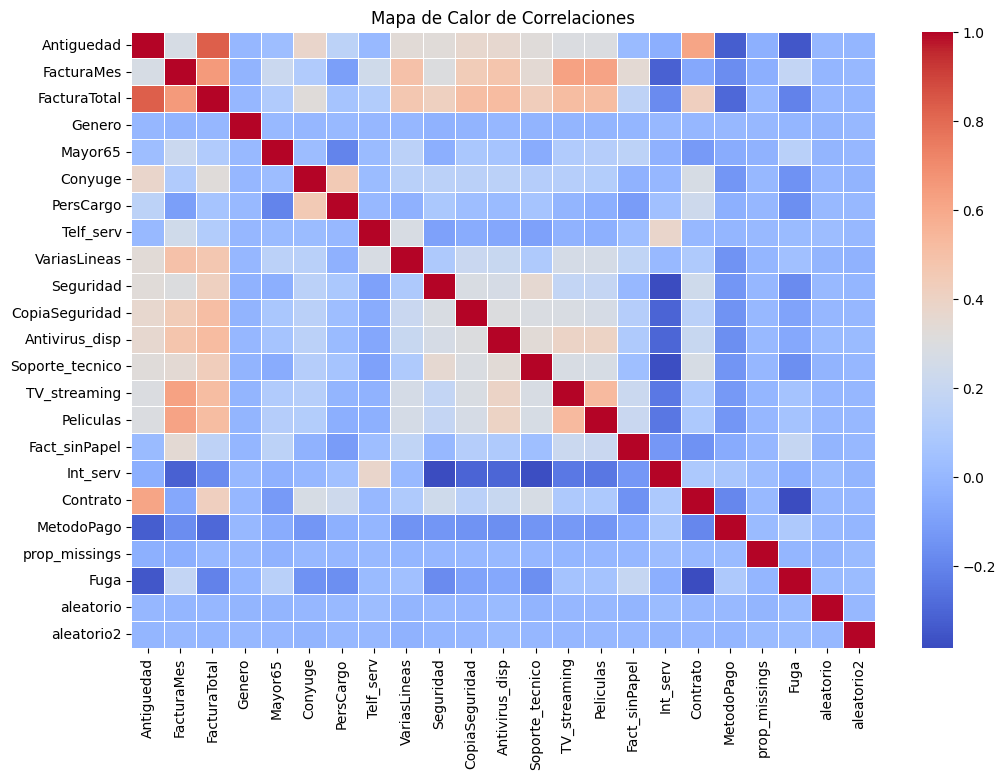

In [23]:
Fuga_imputed_encoded = Fuga_imputed.copy()
for col in Fuga_imputed_encoded.select_dtypes(include=["object", "category"]).columns:
    Fuga_imputed_encoded[col] = Fuga_imputed_encoded[col].astype("category").cat.codes
 
correlation_matrix = Fuga_imputed_encoded.corr()
 
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)

plt.title("Mapa de Calor de Correlaciones")
plt.show()

In [24]:
tablaCramer = pd.DataFrame(FugaDep.apply(lambda x: cramers_v(x,varObjBin)),columns=['VCramer'])

px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente a Fuga').update_yaxes(categoryorder="total ascending").show()

Para evaluar la relación entre las variables predictoras y la variable objetivo (Fuga), utilizamos la tabla de V de Cramer, arriba representada. Esta técnica nos permite identificar qué variables tienen mayor impacto en la predicción de la fuga de clientes.
A partir del análisis, las variables tentativas para el modelado son:

-Contrato

-Antigüedad

-Int_serv

-MétodoPago

-FacturaMes

-Fact_sinPapel

-FacturaTotal
 
 Vamos ahora a utilizar las funciones gráficas para visualizar las relaciones de las variables con la objetivo binaria. En primer lugar podemos utilizar la función mosaico para estudiar las relaciones entre categóricas y las de boxplot e histograma para valorar las relaciones de los predictores continuos con la objetivo binaria.

<Figure size 640x480 with 0 Axes>

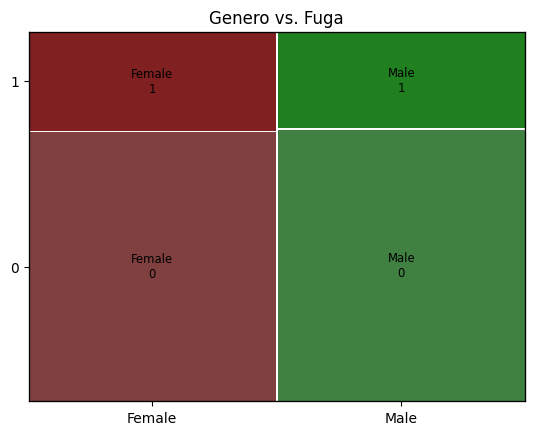

<Figure size 640x480 with 0 Axes>

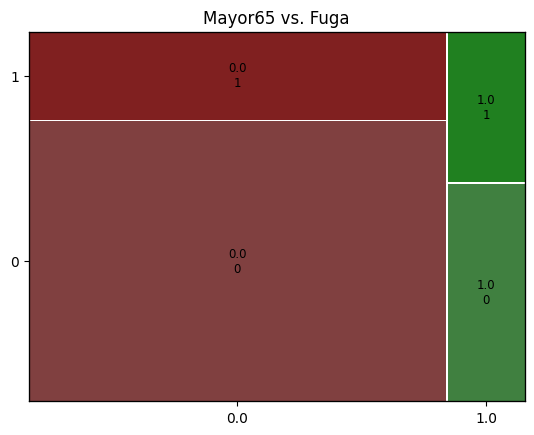

<Figure size 640x480 with 0 Axes>

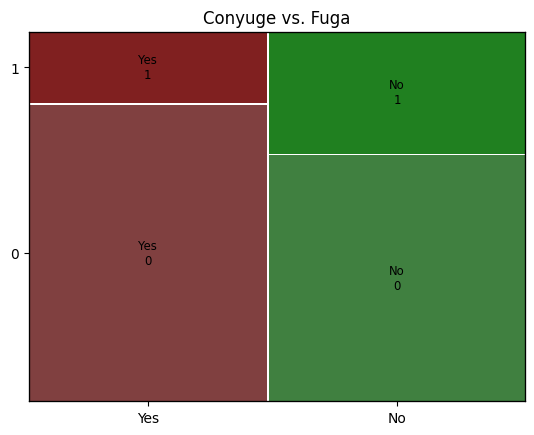

<Figure size 640x480 with 0 Axes>

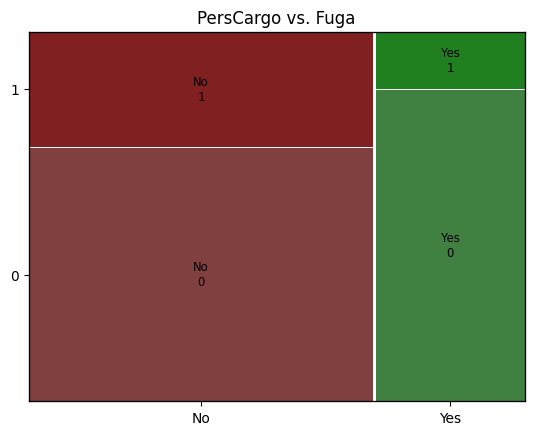

<Figure size 640x480 with 0 Axes>

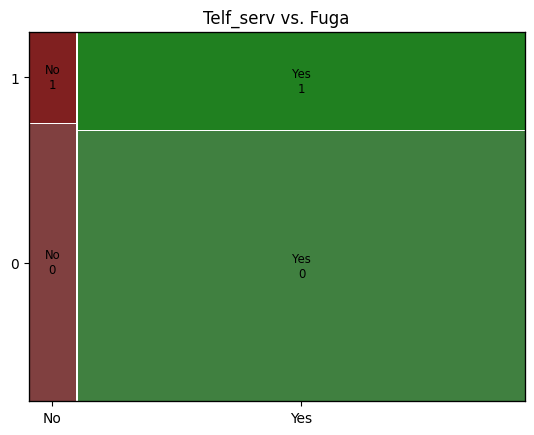

<Figure size 640x480 with 0 Axes>

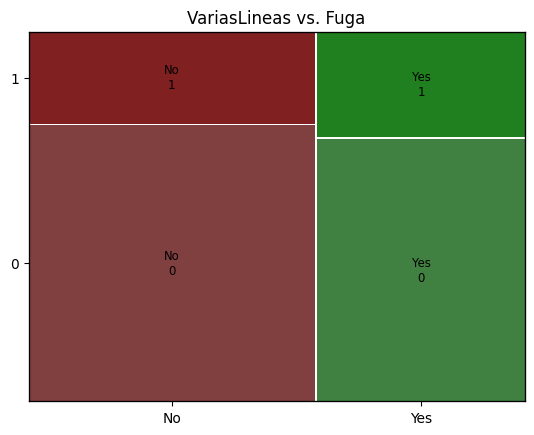

<Figure size 640x480 with 0 Axes>

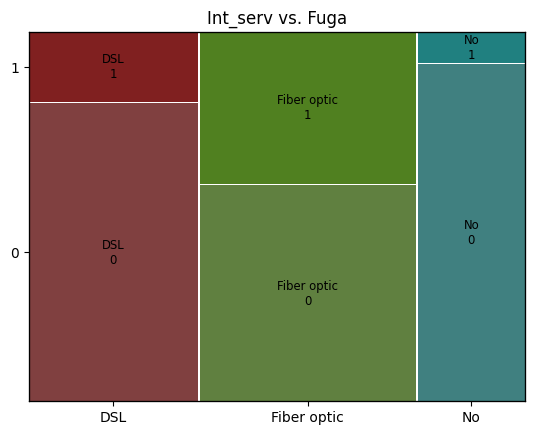

<Figure size 640x480 with 0 Axes>

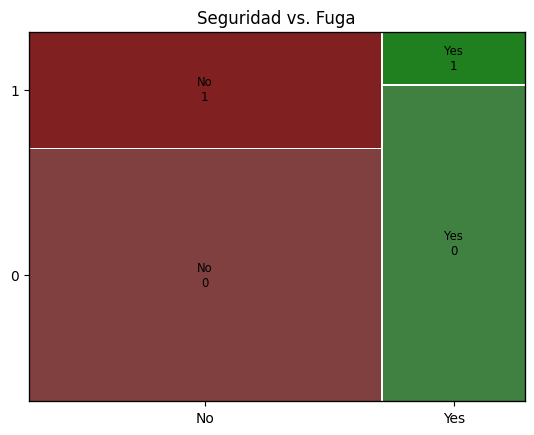

<Figure size 640x480 with 0 Axes>

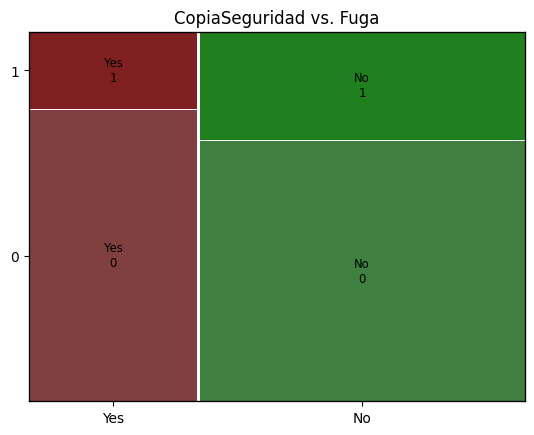

<Figure size 640x480 with 0 Axes>

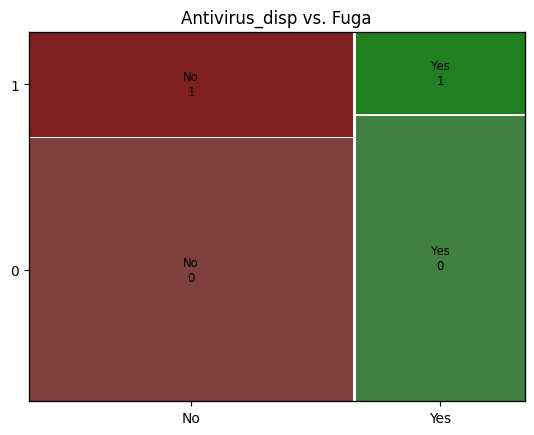

<Figure size 640x480 with 0 Axes>

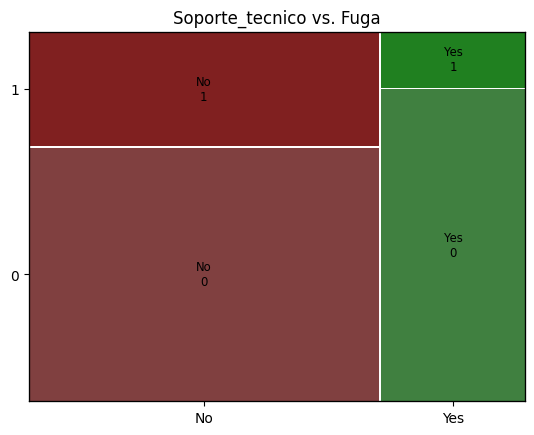

<Figure size 640x480 with 0 Axes>

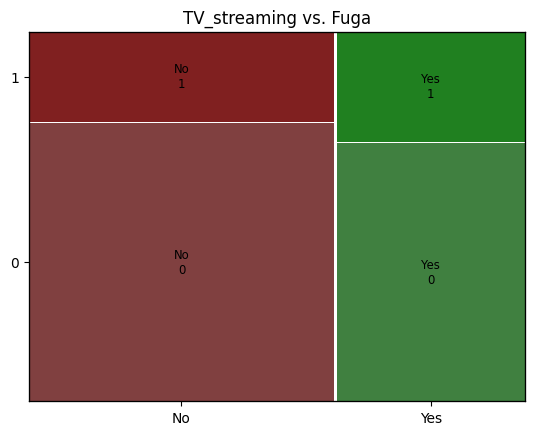

<Figure size 640x480 with 0 Axes>

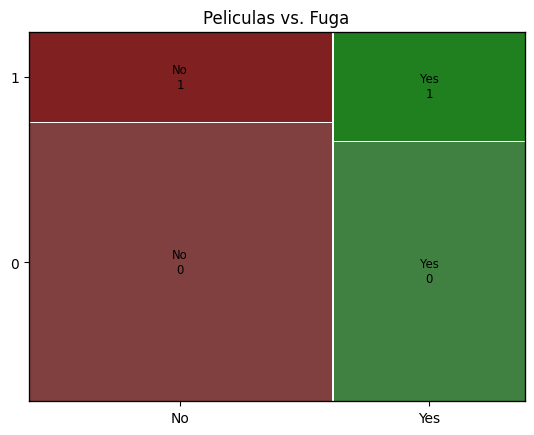

<Figure size 640x480 with 0 Axes>

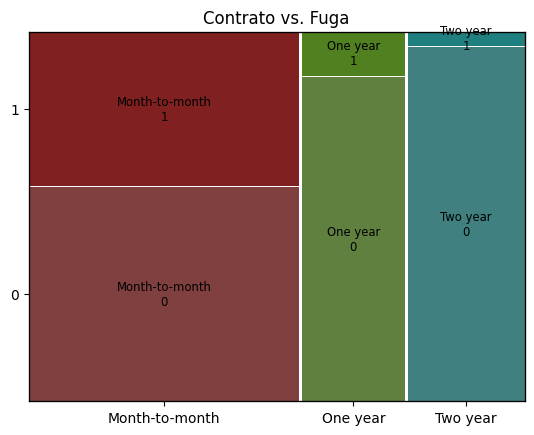

<Figure size 640x480 with 0 Axes>

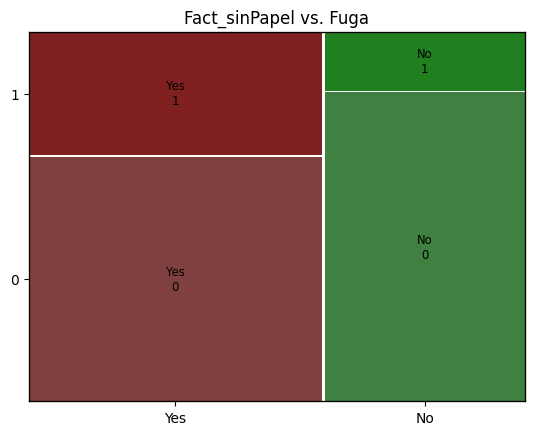

<Figure size 640x480 with 0 Axes>

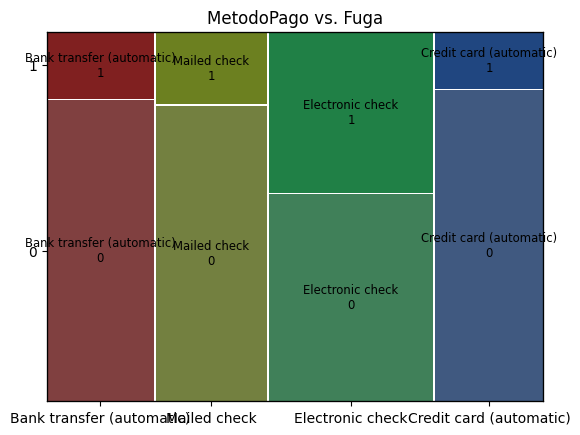

In [25]:
cat_columns = Fuga_cat.columns

for columna in cat_columns:
    plt.clf()
    mosaic.mosaic(Fuga_imputed,[columna,'Fuga'],gap=0.005, title=f'{columna} vs. Fuga')
    plt.show()

Los gráficos de mosaico confirman los resultados del V de Cramer, asegurando que:
1. El tipo de contrato y el servicio de internet están fuertemente relacionados con la fuga. Los clientes con contratos mes a mes y ciertos tipos de internet tienen mayor riesgo de abandono.
2. El género no influye en la fuga, por lo que no es un factor relevante en la retención de clientes.

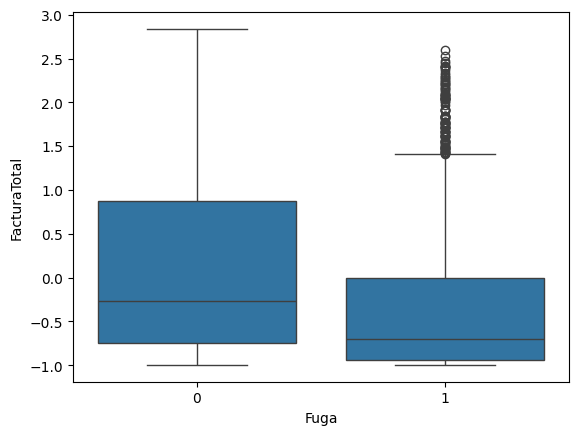

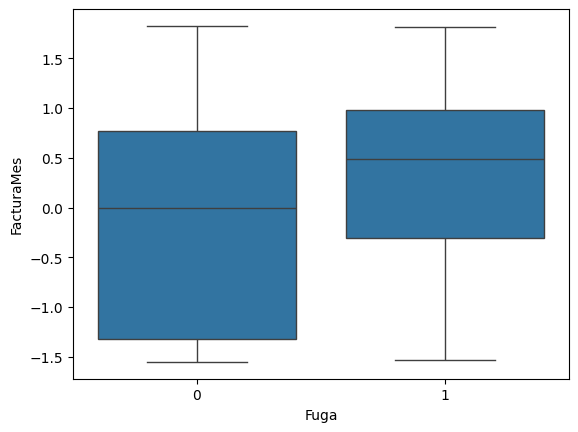

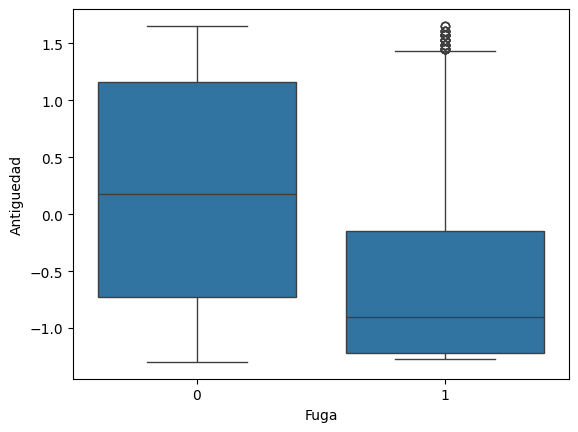

In [26]:
plt.clf()
sns.boxplot(x='Fuga',y='FacturaTotal',data=Fuga_imputed)
plt.show()

plt.clf()
sns.boxplot(x='Fuga',y='FacturaMes',data=Fuga_imputed)
plt.show()

plt.clf()
sns.boxplot(x='Fuga',y='Antiguedad',data=Fuga_imputed)
plt.show()

Los clientes que no han fugado (0) tienen una mayor mediana de facturación y una distribución más amplia de valores.
Los clientes que han fugado (1) tienden a tener facturas totales más bajas, aunque hay algunos valores atípicos de clientes con facturación alta que igual se van.

Los clientes que han fugado (1) tienden a tener una factura mensual más alta en comparación con los que no han fugado.
La mediana de la factura mensual es mayor en el grupo de fuga, lo que indica que los clientes que pagan más al mes tienen mayor probabilidad de abandonar.

Los clientes que no han fugado (0) tienen una antigüedad mucho mayor en comparación con los que han fugado.
Los clientes que han fugado (1) suelen tener una antigüedad baja, con una mediana cercana a los 10 meses y la mayoría por debajo de los 20 meses.
 
Esto nos da una idea de que los clientes que se van no terminan el valor de la empresa
 

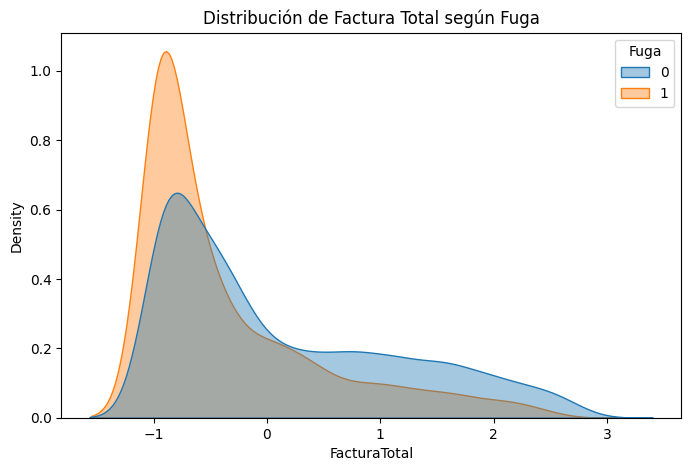

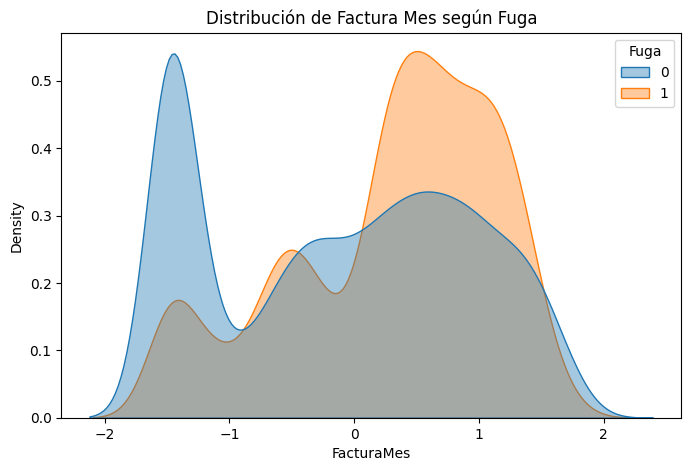

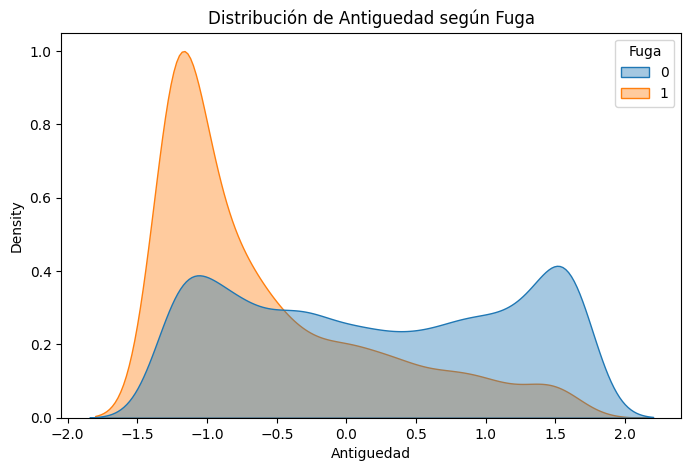

In [27]:
plt.figure(figsize=(8,5))
sns.kdeplot(Fuga_imputed, x="FacturaTotal", hue="Fuga", fill=True, common_norm=False, alpha=0.4)
plt.title("Distribución de Factura Total según Fuga")
plt.show()

plt.figure(figsize=(8,5))
sns.kdeplot(Fuga_imputed, x="FacturaMes", hue="Fuga", fill=True, common_norm=False, alpha=0.4)
plt.title("Distribución de Factura Mes según Fuga")
plt.show()

plt.figure(figsize=(8,5))
sns.kdeplot(Fuga_imputed, x="Antiguedad", hue="Fuga", fill=True, common_norm=False, alpha=0.4)
plt.title("Distribución de Antiguedad según Fuga")
plt.show()

Para evaluar la relación entre las variables numéricas y la fuga de clientes, utilizamos gráficos de densidad y observamos solapamiento en las distribuciones, pero variables como FacturaTotal, FacturaMes y Antigüedad muestran tendencias diferenciadas entre clientes que se fugan y los que no, lo que indica su posible utilidad en el modelo predictivo.

## **3.1. TRANSFORMACION DE VARIABLES**

Vamos a generar las transformaciones de las variable continuas que maximizan la relación con la variable objetivo binaria en sentido de V de Cramer.

In [28]:
transf_cramer = FugaDep.select_dtypes(include=np.number).apply(lambda x: mejorTransf(x,varObjBin, tipo='cramer'))
transf_cramer_names = FugaDep.select_dtypes(include=np.number).apply(lambda x: mejorTransf(x,varObjBin,tipo='cramer', name=True))
transf_cramer.columns = transf_cramer_names.values
transf_cramer

,Antiguedad_raiz4,FacturaMes_raiz4,FacturaTotal_raiz4,prop_missings_ident,aleatorio_cuarta,aleatorio2_raiz4
0,0.450209,0.614416,0.265853,3.098396,10.077602,1.214068
1,1.086494,1.077440,0.954155,1.549248,55.472292,1.329269
2,0.535229,1.045722,0.446326,0.000100,147.316367,1.251844
3,1.165356,0.948063,0.947878,3.098396,28.964798,1.107774
4,0.619867,1.152093,0.492753,1.549248,32.675867,0.991264
...,...,...,...,...,...,...
6348,1.310649,0.558799,0.887567,0.000100,7.986469,1.247608
6349,0.995895,1.222747,0.966780,0.000100,1.919719,1.324150
6350,1.310649,1.299689,1.343052,1.549248,0.708805,0.902166
6351,0.636401,1.171893,0.597672,1.549248,0.019289,1.069475


In [29]:
Fuga_transf = FugaDep.join(transf_cramer)

tablaCramer = pd.DataFrame(Fuga_transf.apply(lambda x: cramers_v(x,varObjBin)),columns=['VCramer'])

px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente a Compra').update_yaxes(categoryorder="total ascending").show()
plt.show()

Al transformar las variables continuas con VCramer en todos los casos mejoran su relacion con la variable objetivo.

# **4. MODELADO MANUAL**

In [30]:
Fuga_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6353 entries, 0 to 6352
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Antiguedad       6353 non-null   float64 
 1   FacturaMes       6353 non-null   float64 
 2   FacturaTotal     6353 non-null   float64 
 3   Genero           6353 non-null   category
 4   Mayor65          6353 non-null   category
 5   Conyuge          6353 non-null   category
 6   PersCargo        6353 non-null   category
 7   Telf_serv        6353 non-null   category
 8   VariasLineas     6353 non-null   category
 9   Seguridad        6353 non-null   category
 10  CopiaSeguridad   6353 non-null   category
 11  Antivirus_disp   6353 non-null   category
 12  Soporte_tecnico  6353 non-null   category
 13  TV_streaming     6353 non-null   category
 14  Peliculas        6353 non-null   category
 15  Fact_sinPapel    6353 non-null   category
 16  Int_serv         6353 non-null   category


## **4.1. PARTICION TRAINING-TEST**

In [31]:
Fuga_imputed.Fuga.value_counts(normalize=True)

Fuga
0    0.734614
1    0.265386
Name: proportion, dtype: float64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(Fuga_imputed.drop(['Fuga'], axis=1), Fuga_imputed.Fuga, test_size=0.2, random_state=1234)

print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (5082, 22) (5082,)
Testing dataset shape: (1271, 22) (1271,)


In [33]:
print(y_train.value_counts(normalize=True))

y_test.value_counts(normalize=True)

Fuga
0    0.734947
1    0.265053
Name: proportion, dtype: float64


Fuga
0    0.733281
1    0.266719
Name: proportion, dtype: float64

## **4.2. MODELO COMPLETO DE REFERENCIA**

In [34]:
data_train = X_train.join(y_train.astype('int64'))
data_test = X_test.join(y_test.astype('int64'))

In [35]:
formC=ols_formula(data_train,'Fuga')
formC

'Fuga ~ Antiguedad + FacturaMes + FacturaTotal + Genero + Mayor65 + Conyuge + PersCargo + Telf_serv + VariasLineas + Seguridad + CopiaSeguridad + Antivirus_disp + Soporte_tecnico + TV_streaming + Peliculas + Fact_sinPapel + Int_serv + Contrato + MetodoPago + prop_missings + aleatorio + aleatorio2'

In [36]:
modeloCompleto = logit(formC,data=data_train).fit()
modeloCompleto.summary()

Optimization terminated successfully.
         Current function value: 0.419479
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Fuga   No. Observations:                 5082
Model:                          Logit   Df Residuals:                     5055
Method:                           MLE   Df Model:                           26
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                  0.2746
Time:                        00:11:32   Log-Likelihood:                -2131.8
converged:                       True   LL-Null:                       -2938.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.7076      0.316     -2.239      0.025      -1.327      -0.088
Genero[T.Male]                           -0.0357      0.076     -0.469      0.639      -0.185       0.113
Mayor65[T.1.0]                            0.1846      0.102      1.805      0.071      -0.016       0.385
Conyuge[T.Yes]                           -0.0357      0.091     -0.391      0.696      -0.215       0.143
PersCargo[T.Yes]                         -0.1481      0.104     -1.427      0.154      -0.352       0.055
Telf_serv[T.Yes]                         -0.8468      0.196     -4.312      0.000      -1.232      -0.462
VariasLineas[T.Yes]                       0.2188      0.099      2.221      0.026       0.026       0.412
Seguridad[T.Yes]                         -0.4870      0.105     -4.645      0.000      -0.692      -0.282
CopiaSeguridad[T.Yes]                    -0.2837      0.096     -2.943      0.003      -0.473      -0.095
Antivirus_disp[T.Yes]                    -0.0571      0.098     -0.582      0.561      -0.249       0.135
Soporte_tecnico[T.Yes]                   -0.4951      0.105     -4.738      0.000      -0.700      -0.290
TV_streaming[T.Yes]                       0.1060      0.114      0.932      0.351      -0.117       0.329
Peliculas[T.Yes]                          0.0472      0.113      0.417      0.677      -0.175       0.269
Fact_sinPapel[T.Yes]                      0.5030      0.087      5.796      0.000       0.333       0.673
Int_serv[T.Fiber optic]                   0.3301      0.173      1.912      0.056      -0.008       0.668
Int_serv[T.No]                           -0.3040      0.204     -1.492      0.136      -0.703       0.095
Contrato[T.One year]                     -0.5752      0.120     -4.791      0.000      -0.810      -0.340
Contrato[T.Two year]                     -1.1306      0.175     -6.475      0.000      -1.473      -0.788
MetodoPago[T.Credit card (automatic)]    -0.2705      0.132     -2.057      0.040      -0.528      -0.013
MetodoPago[T.Electronic check]            0.2324      0.109      2.138      0.033       0.019       0.446
MetodoPago[T.Mailed check]               -0.1006      0.128     -0.784      0.433      -0.352       0.151
Antiguedad                               -1.2894      0.154     -8.382      0.000      -1.591      -0.988
FacturaMes                                0.4991      0.180      2.771      0.006       0.146       0.852
FacturaTotal                              0.4611      0.163      2.830      0.005       0.142       0.780
prop_missings                             0.0009      0.012      0.071      0.943      -0.023       0.025
aleatorio                                 0.2118      0.133      1.591      0.112      -0.049       0.473
aleatorio2                                0.0806      0.132      0.610      0.542      -0.178       0.339
=============================================================

## **4.3. IMPORTANCIA DE LAS VARIABLES**

In [37]:
y_tr, X_tr = patsy.dmatrices(formC, data_train, return_type='dataframe')

y_tst, X_tst = patsy.dmatrices(formC, data_test, return_type='dataframe')

In [38]:
names=X_tr.columns.tolist()[1:]

df_results = relativeImp(X_tr.join(y_tr), outcomeName = 'Fuga', driverNames = names)
 
df_results.sort_values(by='normRelaImpt', ascending=False)

,driver,rawRelaImpt,normRelaImpt
20,Antiguedad,0.039628,14.346379
13,Int_serv[T.Fiber optic],0.027413,9.924345
22,FacturaTotal,0.025863,9.363366
16,Contrato[T.Two year],0.024797,8.977148
18,MetodoPago[T.Electronic check],0.019345,7.003631
14,Int_serv[T.No],0.016577,6.001245
15,Contrato[T.One year],0.016569,5.998586
21,FacturaMes,0.016523,5.981929
12,Fact_sinPapel[T.Yes],0.015211,5.506976
9,Soporte_tecnico[T.Yes],0.011695,4.233795


## **4.4. METRICAS DE AJUSTE EN TRAINING - TEST**

In [39]:
modelo = LogisticRegression(solver='lbfgs', max_iter=1000, penalty=None)

y_tr_ = y_tr.Fuga.ravel()

modelLog = modelo.fit(X_tr,y_tr_)

acc = modelLog.score(X_tr,y_tr_)
print(acc)

y_pred = modelLog.predict(X_tst)

print(metrics.confusion_matrix(y_tst,y_pred))

print(metrics.classification_report(y_tst,y_pred))

metrics.roc_auc_score(y_tr, modelLog.predict_proba(X_tr)[:, 1])


C:\Users\Juan Carbonell\AppData\Local\Temp\ipykernel_9676\1317498908.py:3: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



0.8038173947264856
[[849  83]
 [144 195]]
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       932
         1.0       0.70      0.58      0.63       339

    accuracy                           0.82      1271
   macro avg       0.78      0.74      0.76      1271
weighted avg       0.81      0.82      0.82      1271



np.float64(0.8426654899727593)

El modelo completo ha alcanzado un F1-score general de 0.82, lo que indica un buen balance general, pero sigue mostrando un sesgo hacia la clase mayoritaria (clase 0, clientes que no se fugan). Esto se refleja en un recall bajo (0.59) para la clase 1 (clientes que se fugan), lo que significa que el modelo no está detectando correctamente a todos los clientes en riesgo de fuga.
Dado que los datos están desbalanceados, evaluaremos diferentes modelos y estrategias para mejorar la detección de la clase minoritaria.
 

In [40]:
form1 = 'Fuga ~ Antiguedad + Int_serv + FacturaTotal'

modelo1 = logit(form1,data=data_train).fit()
modelo1.summary()

Optimization terminated successfully.
         Current function value: 0.450957
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Fuga   No. Observations:                 5082
Model:                          Logit   Df Residuals:                     5077
Method:                           MLE   Df Model:                            4
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                  0.2202
Time:                        00:11:32   Log-Likelihood:                -2291.8
converged:                       True   LL-Null:                       -2938.8
Covariance Type:            nonrobust   LLR p-value:                6.419e-279
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.7755      0.071    -24.992      0.000      -1.915      -1.636
Int_serv[T.Fiber optic]     1.2084      0.090     13.399      0.000       1.032       1.385
Int_serv[T.No]             -1.0681      0.130     -8.234      0.000      -1.322      -0.814
Antiguedad                 -1.4413      0.136    -10.623      0.000      -1.707      -1.175
FacturaTotal                0.3490      0.132      2.646      0.008       0.091       0.608
===========================================================================================
"""

In [41]:
form2 = 'Fuga ~ Antiguedad + Int_serv + FacturaTotal + Contrato + FacturaMes + Fact_sinPapel'

modelo2 = logit(form2,data=data_train).fit()
modelo2.summary()

Optimization terminated successfully.
         Current function value: 0.434193
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Fuga   No. Observations:                 5082
Model:                          Logit   Df Residuals:                     5073
Method:                           MLE   Df Model:                            8
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                  0.2492
Time:                        00:11:33   Log-Likelihood:                -2206.6
converged:                       True   LL-Null:                       -2938.8
Covariance Type:            nonrobust   LLR p-value:                6.498e-311
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.6694      0.104    -16.126      0.000      -1.872      -1.467
Int_serv[T.Fiber optic]     0.7488      0.126      5.923      0.000       0.501       0.997
Int_serv[T.No]             -0.5858      0.160     -3.656      0.000      -0.900      -0.272
Contrato[T.One year]       -0.7565      0.116     -6.525      0.000      -0.984      -0.529
Contrato[T.Two year]       -1.4185      0.169     -8.373      0.000      -1.751      -1.086
Fact_sinPapel[T.Yes]        0.5989      0.084      7.109      0.000       0.434       0.764
Antiguedad                 -1.2144      0.148     -8.211      0.000      -1.504      -0.925
FacturaTotal                0.3535      0.154      2.294      0.022       0.051       0.656
FacturaMes                  0.1929      0.098      1.971      0.049       0.001       0.385
===========================================================================================
"""

In [42]:
form3 = 'Fuga ~ Antiguedad + Int_serv + FacturaTotal + Contrato + FacturaMes + Fact_sinPapel + Soporte_tecnico + Seguridad + CopiaSeguridad'

modelo3 = logit(form3,data=data_train).fit()
modelo3.summary()

Optimization terminated successfully.
         Current function value: 0.427204
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Fuga   No. Observations:                 5082
Model:                          Logit   Df Residuals:                     5070
Method:                           MLE   Df Model:                           11
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                  0.2612
Time:                        00:11:33   Log-Likelihood:                -2171.0
converged:                       True   LL-Null:                       -2938.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.1135      0.124     -8.972      0.000      -1.357      -0.870
Int_serv[T.Fiber optic]     0.3211      0.138      2.331      0.020       0.051       0.591
Int_serv[T.No]             -0.7332      0.161     -4.544      0.000      -1.049      -0.417
Contrato[T.One year]       -0.6516      0.118     -5.530      0.000      -0.883      -0.421
Contrato[T.Two year]       -1.2209      0.172     -7.101      0.000      -1.558      -0.884
Fact_sinPapel[T.Yes]        0.5652      0.085      6.626      0.000       0.398       0.732
Soporte_tecnico[T.Yes]     -0.5425      0.100     -5.426      0.000      -0.738      -0.347
Seguridad[T.Yes]           -0.5548      0.099     -5.578      0.000      -0.750      -0.360
CopiaSeguridad[T.Yes]      -0.2573      0.091     -2.816      0.005      -0.436      -0.078
Antiguedad                 -1.2546      0.150     -8.381      0.000      -1.548      -0.961
FacturaTotal                0.4956      0.157      3.156      0.002       0.188       0.803
FacturaMes                  0.4302      0.103      4.161      0.000       0.228       0.633
===========================================================================================
"""

In [43]:
form4 = 'Fuga ~ Antiguedad + Int_serv + FacturaTotal + Contrato + FacturaMes + Fact_sinPapel + Soporte_tecnico + Seguridad + CopiaSeguridad + Telf_serv + VariasLineas + MetodoPago'

modelo4 = logit(form4,data=data_train).fit()
modelo4.summary()

Optimization terminated successfully.
         Current function value: 0.420657
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Fuga   No. Observations:                 5082
Model:                          Logit   Df Residuals:                     5065
Method:                           MLE   Df Model:                           16
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                  0.2726
Time:                        00:11:34   Log-Likelihood:                -2137.8
converged:                       True   LL-Null:                       -2938.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.4629      0.209     -2.219      0.026      -0.872      -0.054
Int_serv[T.Fiber optic]                   0.2890      0.141      2.050      0.040       0.013       0.565
Int_serv[T.No]                           -0.2444      0.183     -1.332      0.183      -0.604       0.115
Contrato[T.One year]                     -0.5943      0.119     -4.994      0.000      -0.828      -0.361
Contrato[T.Two year]                     -1.1587      0.173     -6.691      0.000      -1.498      -0.819
Fact_sinPapel[T.Yes]                      0.5209      0.086      6.033      0.000       0.352       0.690
Soporte_tecnico[T.Yes]                   -0.5252      0.102     -5.134      0.000      -0.726      -0.325
Seguridad[T.Yes]                         -0.5116      0.101     -5.070      0.000      -0.709      -0.314
CopiaSeguridad[T.Yes]                    -0.3056      0.093     -3.294      0.001      -0.487      -0.124
Telf_serv[T.Yes]                         -0.9377      0.166     -5.636      0.000      -1.264      -0.612
VariasLineas[T.Yes]                       0.2137      0.095      2.243      0.025       0.027       0.400
MetodoPago[T.Credit card (automatic)]    -0.2825      0.131     -2.152      0.031      -0.540      -0.025
MetodoPago[T.Electronic check]            0.2507      0.108      2.315      0.021       0.038       0.463
MetodoPago[T.Mailed check]               -0.1086      0.128     -0.849      0.396      -0.359       0.142
Antiguedad                               -1.3176      0.151     -8.735      0.000      -1.613      -1.022
FacturaTotal                              0.4879      0.158      3.093      0.002       0.179       0.797
FacturaMes                                0.5941      0.119      5.004      0.000       0.361       0.827
=========================================================================================================
"""

In [44]:
form5 = 'Fuga ~ Antiguedad*FacturaTotal + FacturaMes + Contrato + Int_serv + Fact_sinPapel + Soporte_tecnico + Seguridad + CopiaSeguridad + Telf_serv + VariasLineas + MetodoPago'

modelo5 = logit(form5,data=data_train).fit()
modelo5.summary()

Optimization terminated successfully.
         Current function value: 0.419523
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Fuga   No. Observations:                 5082
Model:                          Logit   Df Residuals:                     5064
Method:                           MLE   Df Model:                           17
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                  0.2745
Time:                        00:11:34   Log-Likelihood:                -2132.0
converged:                       True   LL-Null:                       -2938.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.6128      0.214     -2.862      0.004      -1.032      -0.193
Contrato[T.One year]                     -0.5822      0.119     -4.879      0.000      -0.816      -0.348
Contrato[T.Two year]                     -1.2572      0.178     -7.081      0.000      -1.605      -0.909
Int_serv[T.Fiber optic]                   0.3010      0.142      2.117      0.034       0.022       0.580
Int_serv[T.No]                           -0.2304      0.185     -1.248      0.212      -0.592       0.131
Fact_sinPapel[T.Yes]                      0.5254      0.087      6.055      0.000       0.355       0.695
Soporte_tecnico[T.Yes]                   -0.5047      0.103     -4.914      0.000      -0.706      -0.303
Seguridad[T.Yes]                         -0.5082      0.101     -5.031      0.000      -0.706      -0.310
CopiaSeguridad[T.Yes]                    -0.3046      0.093     -3.270      0.001      -0.487      -0.122
Telf_serv[T.Yes]                         -0.9519      0.167     -5.686      0.000      -1.280      -0.624
VariasLineas[T.Yes]                       0.2473      0.097      2.558      0.011       0.058       0.437
MetodoPago[T.Credit card (automatic)]    -0.2876      0.131     -2.193      0.028      -0.545      -0.031
MetodoPago[T.Electronic check]            0.2421      0.108      2.234      0.025       0.030       0.454
MetodoPago[T.Mailed check]               -0.1269      0.129     -0.987      0.324      -0.379       0.125
Antiguedad                               -1.0659      0.172     -6.206      0.000      -1.403      -0.729
FacturaTotal                              0.1464      0.192      0.763      0.445      -0.230       0.522
Antiguedad:FacturaTotal                   0.2087      0.062      3.376      0.001       0.088       0.330
FacturaMes                                0.6615      0.123      5.397      0.000       0.421       0.902
=========================================================================================================
"""

# **5. MODELADO POR SELECCION DE VARIABLES**

In [45]:
Fuga_transf = Fuga_transf.loc[:,~Fuga_transf.columns.str.contains('aleat', case=False)]
Fuga_transf.nunique()

Antiguedad              225
FacturaMes             1840
FacturaTotal           5934
Genero                    2
Mayor65                   2
Conyuge                   2
PersCargo                 2
Telf_serv                 2
VariasLineas              2
Seguridad                 2
CopiaSeguridad            2
Antivirus_disp            2
Soporte_tecnico           2
TV_streaming              2
Peliculas                 2
Fact_sinPapel             2
Int_serv                  3
Contrato                  3
MetodoPago                4
prop_missings             4
Antiguedad_raiz4        225
FacturaMes_raiz4       1834
FacturaTotal_raiz4     5934
prop_missings_ident       4
dtype: int64

In [46]:
Fuga_dummy = pd.get_dummies(Fuga_transf, columns = cat_columns, drop_first=False)

Fuga_dummy

,Antiguedad,FacturaMes,FacturaTotal,prop_missings,Antiguedad_raiz4,FacturaMes_raiz4,FacturaTotal_raiz4,prop_missings_ident,Genero_Female,Genero_Male,...,Peliculas_Yes,Contrato_Month-to-month,Contrato_One year,Contrato_Two year,Fact_sinPapel_No,Fact_sinPapel_Yes,MetodoPago_Bank transfer (automatic),MetodoPago_Credit card (automatic),MetodoPago_Electronic check,MetodoPago_Mailed check
0,-1.256294,-1.408340,-0.991147,9.523810,0.450209,0.614416,0.265853,3.098396,True,False,...,False,True,False,False,False,True,True,False,False,False
1,0.096129,-0.203215,-0.167291,4.761905,1.086494,1.077440,0.954155,1.549248,False,True,...,False,False,True,False,True,False,False,False,False,True
2,-1.215311,-0.355031,-0.956459,0.000000,0.535229,1.045722,0.446326,0.000100,False,True,...,False,True,False,False,False,True,False,False,False,True
3,0.546936,-0.742969,-0.188888,9.523810,1.165356,0.948063,0.947878,3.098396,True,False,...,False,False,True,False,True,False,False,False,True,False
4,-1.149739,0.210920,-0.937187,4.761905,0.619867,1.152093,0.492753,1.549248,True,False,...,False,True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6348,1.653464,-1.453347,-0.375553,0.000000,1.310649,0.558799,0.887567,0.000100,True,False,...,False,False,False,True,False,True,True,False,False,False
6349,-0.313696,0.684506,-0.122546,0.000000,0.995895,1.222747,0.966780,0.000100,False,True,...,True,False,True,False,False,True,False,False,False,True
6350,1.653464,1.302518,2.257516,4.761905,1.310649,1.299689,1.343052,1.549248,False,True,...,True,False,True,False,False,True,False,True,False,False
6351,-1.133346,0.335195,-0.868542,4.761905,0.636401,1.171893,0.597672,1.549248,False,True,...,False,False,True,False,False,True,False,False,False,True


In [47]:
Fuga_dummy.drop(['Genero_Female','Mayor65_0.0',
                  'Conyuge_No', 'PersCargo_No', 
                  'Telf_serv_No', 'VariasLineas_No', 
                  'Seguridad_No', 'CopiaSeguridad_No', 
                  'Antivirus_disp_No', 'Soporte_tecnico_No', 
                  'TV_streaming_No', 'Peliculas_No', 
                  'Fact_sinPapel_No', 'Int_serv_DSL', 
                  'Contrato_Month-to-month', 'MetodoPago_Bank transfer (automatic)'], axis=1, inplace=True)


Fuga_dummy=sm.add_constant(Fuga_dummy)

Fuga_dummy = pd.concat([Fuga_dummy.select_dtypes(exclude=['bool']),Fuga_dummy.select_dtypes(include=['bool']).astype('category')],axis=1)

## **5.1 METODOS SEQUENCIALES**

### **5.1.1 BACKWARD ELIMINATION**

In [48]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, penalty=None)

sfs_back = sfs(clf,k_features = 'best',
               forward=False,
               floating=False, 
               scoring='r2',
               cv=5,
               n_jobs=-1)

sfs_back = sfs_back.fit(Fuga_dummy, varObjBin)

print(sfs_back.k_feature_names_)

sfs_back.k_score_

('Antiguedad', 'FacturaMes', 'FacturaTotal', 'prop_missings', 'Antiguedad_raiz4', 'FacturaMes_raiz4', 'FacturaTotal_raiz4', 'prop_missings_ident', 'Genero_Male', 'PersCargo_Yes', 'Telf_serv_Yes', 'VariasLineas_Yes', 'Int_serv_Fiber optic', 'Seguridad_Yes', 'CopiaSeguridad_Yes', 'Soporte_tecnico_Yes', 'TV_streaming_Yes', 'Peliculas_Yes', 'Contrato_One year', 'Contrato_Two year', 'Fact_sinPapel_Yes', 'MetodoPago_Electronic check', 'MetodoPago_Mailed check')


np.float64(0.024695707979384186)

In [49]:
pd.DataFrame.from_dict(sfs_back.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
29,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.014722421669981278, -0.037771875536126265, ...",-0.001146,"(const, Antiguedad, FacturaMes, FacturaTotal, ...",0.045392,0.035317,0.017658
28,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14,...","[0.03087451311801437, -0.017581761226084902, -...",0.006928,"(const, Antiguedad, FacturaMes, FacturaTotal, ...",0.04034,0.031386,0.015693
27,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14,...","[0.042988581704039186, -0.017581761226084902, ...",0.015812,"(const, Antiguedad, FacturaMes, FacturaTotal, ...",0.047194,0.036718,0.018359
26,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15,...","[0.03895055884203091, -0.009505715502068357, -...",0.019851,"(const, Antiguedad, FacturaMes, FacturaTotal, ...",0.046779,0.036396,0.018198
25,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16...","[0.04702660456604746, -0.009505715502068357, -...",0.021464,"(Antiguedad, FacturaMes, FacturaTotal, prop_mi...",0.04639,0.036093,0.018046
24,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 17...","[0.05106462742805573, -0.0054676926400600845, ...",0.023887,"(Antiguedad, FacturaMes, FacturaTotal, prop_mi...",0.045394,0.035318,0.017659
23,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 17...","[0.03895055884203091, -0.001429669778051812, -...",0.024696,"(Antiguedad, FacturaMes, FacturaTotal, prop_mi...",0.051611,0.040155,0.020077
22,"(1, 2, 3, 5, 6, 7, 8, 9, 12, 13, 14, 15, 17, 1...","[0.03895055884203091, -0.001429669778051812, -...",0.023888,"(Antiguedad, FacturaMes, FacturaTotal, Antigue...",0.049905,0.038828,0.019414
21,"(1, 2, 3, 5, 6, 7, 9, 12, 13, 14, 15, 17, 18, ...","[0.03087451311801437, 0.006646375945964733, -0...",0.022276,"(Antiguedad, FacturaMes, FacturaTotal, Antigue...",0.051091,0.039751,0.019875
20,"(1, 2, 3, 5, 6, 7, 12, 13, 14, 15, 17, 18, 20,...","[0.04702660456604746, -0.001429669778051812, -...",0.022277,"(Antiguedad, FacturaMes, FacturaTotal, Antigue...",0.053717,0.041794,0.020897


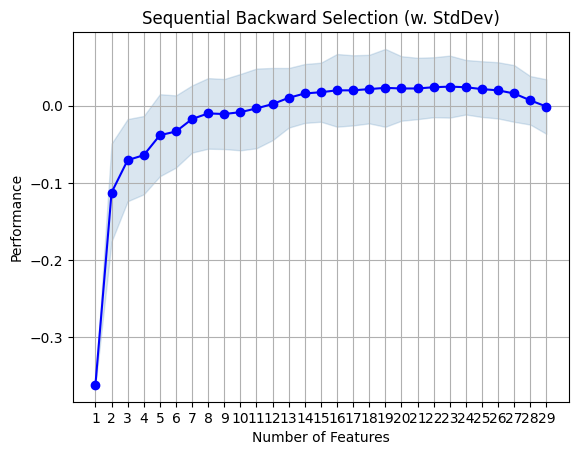

In [50]:
fig1 = plot_sfs(sfs_back.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

El resultado del gráfico indica que el punto óptimo parace estar enre 10 y 19 variables, que supone un desempeño estable del modelo.
 
Una eliminacion de variables innecesaria mejoraria eficiencia y generalizacion del modelo pero si eliminamos demasiadas puede haber perdida e información.
 
Para ello ejecutamos diferentes métodos que nos permitan detectar las variables ideales para el modelo y concluir con el modelo ganador.
 
- Método Forward selection (parsimonious)
- Método Backward con 20 variables
- Método Backward con 10 variables

### **5.1.2 FORWARD - PARSIMONIOUS**

In [51]:
sfs_forw = sfs(clf, 
          k_features='parsimonious', 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=5, n_jobs=-1)

sfs_forw = sfs_forw.fit(Fuga_dummy, varObjBin)

print('\nSequential Forward Selection:')
print(sfs_forw.k_feature_names_)
print('CV Score:')
print(sfs_forw.k_score_)


Sequential Forward Selection:
('Antiguedad', 'FacturaMes', 'Antiguedad_raiz4', 'FacturaTotal_raiz4', 'Telf_serv_Yes', 'Int_serv_Fiber optic', 'Seguridad_Yes', 'Soporte_tecnico_Yes', 'Fact_sinPapel_Yes', 'MetodoPago_Electronic check', 'MetodoPago_Mailed check')
CV Score:
0.01097092897438472


In [52]:
pd.DataFrame.from_dict(sfs_forw.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(5,)","[-0.24371104149854816, -0.32043347587670534, -...",-0.27727,"(Antiguedad_raiz4,)",0.053503,0.041627,0.020813
2,"(2, 5)","[-0.04988594412215108, -0.1346844242243248, -0...",-0.089158,"(FacturaMes, Antiguedad_raiz4)",0.041144,0.032012,0.016006
3,"(2, 5, 13)","[-0.04584792126014281, -0.13064640136231653, -...",-0.077049,"(FacturaMes, Antiguedad_raiz4, Telf_serv_Yes)",0.041268,0.032108,0.016054
4,"(2, 5, 13, 20)","[0.006646375945964733, -0.09834221846625035, -...",-0.052004,"(FacturaMes, Antiguedad_raiz4, Telf_serv_Yes, ...",0.061306,0.047699,0.023849
5,"(2, 5, 7, 13, 20)","[0.01876044453198955, -0.09834221846625035, -0...",-0.050386,"(FacturaMes, Antiguedad_raiz4, FacturaTotal_ra...",0.066326,0.051604,0.025802
6,"(2, 5, 7, 13, 15, 20)","[0.014722421669981278, -0.07815210415620899, -...",-0.047967,"(FacturaMes, Antiguedad_raiz4, FacturaTotal_ra...",0.057942,0.045081,0.02254
7,"(2, 5, 7, 13, 15, 20, 27)","[0.03491253598002264, -0.07411408129420072, -0...",-0.03424,"(FacturaMes, Antiguedad_raiz4, FacturaTotal_ra...",0.063156,0.049138,0.024569
8,"(2, 5, 7, 13, 15, 17, 20, 27)","[0.010684398807973006, -0.04180989839813454, -...",-0.010835,"(FacturaMes, Antiguedad_raiz4, FacturaTotal_ra...",0.04147,0.032265,0.016132
9,"(2, 5, 7, 13, 15, 17, 20, 25, 27)","[0.026836490256006096, -0.053923966984159355, ...",-0.004363,"(FacturaMes, Antiguedad_raiz4, FacturaTotal_ra...",0.073654,0.057305,0.028653
10,"(1, 2, 5, 7, 13, 15, 17, 20, 25, 27)","[0.055102650290064004, -0.053923966984159355, ...",0.004511,"(Antiguedad, FacturaMes, Antiguedad_raiz4, Fac...",0.067523,0.052535,0.026267


### **5.1.3 BACKWARD CON 19 VARIABLES**

In [54]:
sfs_20 = sfs(clf, 
          k_features= 20, 
          forward=False, 
          floating=True, 
          scoring='r2',
          cv=5)

sfs_20 = sfs_20.fit(Fuga_dummy, varObjBin)

print('\nSequential Forward Selection (k=19):')
print(sfs_20.k_feature_names_)
print('CV Score:')
print(sfs_20.k_score_)


Sequential Forward Selection (k=19):
('Antiguedad', 'FacturaMes', 'FacturaTotal', 'Antiguedad_raiz4', 'FacturaMes_raiz4', 'FacturaTotal_raiz4', 'PersCargo_Yes', 'Telf_serv_Yes', 'VariasLineas_Yes', 'Int_serv_Fiber optic', 'Seguridad_Yes', 'CopiaSeguridad_Yes', 'Soporte_tecnico_Yes', 'TV_streaming_Yes', 'Peliculas_Yes', 'Contrato_One year', 'Contrato_Two year', 'Fact_sinPapel_Yes', 'MetodoPago_Electronic check', 'MetodoPago_Mailed check')
CV Score:
0.02227701421381496


### **5.1.4 BACKWARD CON 10 VARIABLES**

In [55]:
sfs_10 = sfs(clf, 
          k_features= 10, 
          forward=False, 
          floating=True, 
          scoring='r2',
          cv=5, n_jobs=-1)

sfs_10 = sfs_10.fit(Fuga_dummy, varObjBin)

print('\nSequential Backward Selection (k=10):')
print(sfs_10.k_feature_names_)
print('CV Score:')
print(sfs_10.k_score_)



Sequential Backward Selection (k=10):
('FacturaMes', 'Antiguedad_raiz4', 'Telf_serv_Yes', 'VariasLineas_Yes', 'Seguridad_Yes', 'CopiaSeguridad_Yes', 'Soporte_tecnico_Yes', 'Contrato_Two year', 'Fact_sinPapel_Yes', 'MetodoPago_Electronic check')
CV Score:
0.007727841074281571


### **5.1.5 INTERACCION ENTRE VARIABLES**

In [56]:
sel_col = Fuga_dummy.drop(['Antiguedad', 'FacturaMes', 'FacturaTotal', 'prop_missings','prop_missings_ident'], axis=1).columns

Fuga_dummy_red = Fuga_dummy[sel_col].drop(['const'], axis=1)
Fuga_dummy_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6353 entries, 0 to 6352
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   Antiguedad_raiz4                    6353 non-null   float64 
 1   FacturaMes_raiz4                    6353 non-null   float64 
 2   FacturaTotal_raiz4                  6353 non-null   float64 
 3   Genero_Male                         6353 non-null   category
 4   Mayor65_1.0                         6353 non-null   category
 5   Conyuge_Yes                         6353 non-null   category
 6   PersCargo_Yes                       6353 non-null   category
 7   Telf_serv_Yes                       6353 non-null   category
 8   VariasLineas_Yes                    6353 non-null   category
 9   Int_serv_Fiber optic                6353 non-null   category
 10  Int_serv_No                         6353 non-null   category
 11  Seguridad_Yes                 

In [57]:
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interaction

X_inter = pd.DataFrame(interaction.fit_transform(Fuga_dummy_red), columns=interaction.get_feature_names_out(input_features=Fuga_dummy_red.columns))
X_inter.shape

(6353, 276)

In [58]:
X_inter = X_inter.loc[:, X_inter.var() != 0.0]

X_inter.shape

(6353, 271)


Al crear interacciones, esto nos permite modelar relaciones más complejas que no se capturan en un modelo lineal simple. Pero a su vez requerimos depurar el modelo para evitar columnas que no aportan información al modelo porque el valor es el mismo en todos los registros.
Después de la depuración eliminamos 5 columnas constantes que no aportaban información a los modelos. Terminando con 271 variables útiles para seguir entrenando.

## **5.2 SELECCION AUTOMATICA DE INTERACCIONES**

### **5.2.1 METODO SEQUENCIAL**

A continuación, se intentó realizar el método de selección de variables automática por el mejor ajuste. Sin embargo, debido a la gran cantidad de interacciones en el modelo, resultó muy difícil de procesar por la falta de potencia computacional. Por lo tanto, se optó por dejarlo comentado, con el fin de evidenciar cómo se puede llevar a cabo el proceso de selección de variables por el mejor ajuste.

In [59]:
#sfs_forw_int_best = sfs(clf, 
 #         k_features='best', 
 #        forward=True, 
 #         floating=False, 
 #         scoring='r2',
 #         cv=2,n_jobs=-1)

#sfs_forw_int_best = sfs_forw_int_best.fit(X_inter, varObjBin)

#print('\nSequential Forward + Best Selection:')
#print(sfs_forw_int_best.k_feature_names_)
#print('CV Score:')
#print(sfs_forw_int_best.k_score_)

A continuación emplearemos la Selección Secuencial Adelante Automática para elegir las 10 mejores variables del modelo.

In [60]:
sfs_forw_int_10 = sfs(clf, 
          k_features=10, 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=4,n_jobs=-1)

sfs_forw_int_10 = sfs_forw_int_10.fit(X_inter, varObjBin)

print('\nSequential Forward 10 variables Selection:')
print(sfs_forw_int_10.k_feature_names_)
print('CV Score:')
print(sfs_forw_int_10.k_score_)


Sequential Forward 10 variables Selection:
('Antiguedad_raiz4', 'Contrato_Two year', 'FacturaMes_raiz4 VariasLineas_Yes', 'FacturaMes_raiz4 Int_serv_Fiber optic', 'Mayor65_1.0 CopiaSeguridad_Yes', 'Mayor65_1.0 MetodoPago_Mailed check', 'TV_streaming_Yes Peliculas_Yes', 'Peliculas_Yes MetodoPago_Credit card (automatic)', 'Fact_sinPapel_Yes MetodoPago_Credit card (automatic)', 'Fact_sinPapel_Yes MetodoPago_Electronic check')
CV Score:
0.010946120924642477


Con este método obtenemos que el rendimiento del modelo no es como se espera, por lo que intentaremos otros métodos de selección de variables de forma automática, como es el método de LassoLarsIC, que elimina coeficientes, dejando variables con impacto en la respuesta. Este método selecciona variables que ya estaban presentes anteriormente, pero también considera relevantes interacciones entre las variables.

### **5.2.2 METODO LASSO**

In [61]:
reg = linear_model.LassoLarsIC(criterion='bic')

reg.fit(Fuga_dummy, varObjBin)

print(reg.coef_)

[ 0.          0.11767255  0.14039768 -0.11769642  0.00097597 -0.42009586
  0.         -0.2389409   0.         -0.00262531  0.0443266   0.
 -0.01509016 -0.10062456  0.04541136  0.08545541 -0.04982188 -0.06075054
 -0.03561264 -0.00789845 -0.0598451   0.0260638   0.01872834 -0.07833546
 -0.08855279  0.05491539 -0.0089864   0.05664599 -0.01626575]


In [62]:
selec_feats = Fuga_dummy[Fuga_dummy.columns[(reg.coef_ != 0).ravel().tolist()]]
selec_feats.columns

Index(['Antiguedad', 'FacturaMes', 'FacturaTotal', 'prop_missings',
       'Antiguedad_raiz4', 'FacturaTotal_raiz4', 'Genero_Male', 'Mayor65_1.0',
       'PersCargo_Yes', 'Telf_serv_Yes', 'VariasLineas_Yes',
       'Int_serv_Fiber optic', 'Int_serv_No', 'Seguridad_Yes',
       'CopiaSeguridad_Yes', 'Antivirus_disp_Yes', 'Soporte_tecnico_Yes',
       'TV_streaming_Yes', 'Peliculas_Yes', 'Contrato_One year',
       'Contrato_Two year', 'Fact_sinPapel_Yes',
       'MetodoPago_Credit card (automatic)', 'MetodoPago_Electronic check',
       'MetodoPago_Mailed check'],
      dtype='object')

In [63]:
lasso_int = linear_model.LassoLarsIC(criterion='bic')

lasso_int.fit(X_inter, varObjBin)

print(lasso_int.coef_)

[ 0.          0.          0.          0.          0.02745889  0.
 -0.01398439  0.          0.          0.         -0.01141187  0.
  0.          0.          0.          0.          0.         -0.06596271
  0.          0.          0.          0.          0.          0.
 -0.28695227  0.          0.          0.          0.         -0.03051425
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.01038727  0.          0.          0.
  0.          0.          0.          0.04015095  0.1434708   0.
 -0.01204256 -0.01046598  0.         -0.0154877   0.03008884  0.0273651
  0.         -0.05483491  0.05821418  0.          0.04223466  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  

In [64]:
selec_feats_int = X_inter[X_inter.columns[(lasso_int.coef_ != 0).ravel().tolist()]]
selec_feats_int.columns

Index(['Mayor65_1.0', 'PersCargo_Yes', 'Int_serv_No', 'Contrato_One year',
       'Antiguedad_raiz4 FacturaTotal_raiz4', 'Antiguedad_raiz4 Telf_serv_Yes',
       'Antiguedad_raiz4 MetodoPago_Mailed check',
       'FacturaMes_raiz4 VariasLineas_Yes',
       'FacturaMes_raiz4 Int_serv_Fiber optic',
       'FacturaMes_raiz4 Seguridad_Yes', 'FacturaMes_raiz4 CopiaSeguridad_Yes',
       'FacturaMes_raiz4 Soporte_tecnico_Yes',
       'FacturaMes_raiz4 TV_streaming_Yes', 'FacturaMes_raiz4 Peliculas_Yes',
       'FacturaMes_raiz4 Contrato_Two year',
       'FacturaMes_raiz4 Fact_sinPapel_Yes',
       'FacturaMes_raiz4 MetodoPago_Electronic check',
       'Telf_serv_Yes Int_serv_No', 'Int_serv_Fiber optic Seguridad_Yes',
       'Int_serv_Fiber optic Soporte_tecnico_Yes',
       'Int_serv_Fiber optic Contrato_Two year',
       'Int_serv_Fiber optic Fact_sinPapel_Yes',
       'Seguridad_Yes Fact_sinPapel_Yes',
       'Soporte_tecnico_Yes Fact_sinPapel_Yes',
       'Fact_sinPapel_Yes MetodoPago_El

Con el método Lasso obtenemos dos modelos. En el siguiente apartado evaluaremos su desempeño y los compararemos por el metodo de validacion cruzada.

# **6. VALIDACION CRUZADA**

Las validacion cruzada nos permite evaluar y comparar el desempeño de diferentes modelos predictivos de manera más robusta. Para esto dividiremos varias veces los datos en diferentes combinaciones de entrenamiento y prueba. La evaluación se basó en la métrica R² utilizando validación cruzada repetida, lo que permitió obtener una estimación más robusta y confiable del rendimiento de cada modelo.

In [65]:
Fuga_imputed.Fuga = Fuga_imputed.Fuga.astype('int64')
list_form = [formC,form1,form2,form3,form4,form5]

list_res = pd.DataFrame(map(lambda x: cross_val_log(x,Fuga_imputed, seed=2022),list_form))

Modelo: Fuga ~ Antiguedad + FacturaMes + FacturaTotal + Genero + Mayor65 + Conyuge + PersCargo + Telf_serv + VariasLineas + Seguridad + CopiaSeguridad + Antivirus_disp + Soporte_tecnico + TV_streaming + Peliculas + Fact_sinPapel + Int_serv + Contrato + MetodoPago + prop_missings + aleatorio + aleatorio2
AUC: 0.843 (0.012)
Modelo: Fuga ~ Antiguedad + Int_serv + FacturaTotal
AUC: 0.817 (0.013)
Modelo: Fuga ~ Antiguedad + Int_serv + FacturaTotal + Contrato + FacturaMes + Fact_sinPapel
AUC: 0.832 (0.012)
Modelo: Fuga ~ Antiguedad + Int_serv + FacturaTotal + Contrato + FacturaMes + Fact_sinPapel + Soporte_tecnico + Seguridad + CopiaSeguridad
AUC: 0.839 (0.012)
Modelo: Fuga ~ Antiguedad + Int_serv + FacturaTotal + Contrato + FacturaMes + Fact_sinPapel + Soporte_tecnico + Seguridad + CopiaSeguridad + Telf_serv + VariasLineas + MetodoPago
AUC: 0.843 (0.012)
Modelo: Fuga ~ Antiguedad*FacturaTotal + FacturaMes + Contrato + Int_serv + Fact_sinPapel + Soporte_tecnico + Seguridad + CopiaSeguridad +

In [66]:
list_form = [formC,form1,form2,form3,form4,form5]

list_res = pd.DataFrame(map(lambda x: cross_val_lin(x,Fuga_imputed, seed=2022),list_form))

results_manual = list_res.T.melt()
results_manual.columns = ['Modelo','R2']
results_manual.head()

Modelo: Fuga ~ Antiguedad + FacturaMes + FacturaTotal + Genero + Mayor65 + Conyuge + PersCargo + Telf_serv + VariasLineas + Seguridad + CopiaSeguridad + Antivirus_disp + Soporte_tecnico + TV_streaming + Peliculas + Fact_sinPapel + Int_serv + Contrato + MetodoPago + prop_missings + aleatorio + aleatorio2
Coeficiente de determinación R2: 0.276 (0.023)
Modelo: Fuga ~ Antiguedad + Int_serv + FacturaTotal
Coeficiente de determinación R2: 0.232 (0.023)
Modelo: Fuga ~ Antiguedad + Int_serv + FacturaTotal + Contrato + FacturaMes + Fact_sinPapel
Coeficiente de determinación R2: 0.256 (0.022)
Modelo: Fuga ~ Antiguedad + Int_serv + FacturaTotal + Contrato + FacturaMes + Fact_sinPapel + Soporte_tecnico + Seguridad + CopiaSeguridad
Coeficiente de determinación R2: 0.266 (0.022)
Modelo: Fuga ~ Antiguedad + Int_serv + FacturaTotal + Contrato + FacturaMes + Fact_sinPapel + Soporte_tecnico + Seguridad + CopiaSeguridad + Telf_serv + VariasLineas + MetodoPago
Coeficiente de determinación R2: 0.276 (0.023

,Modelo,R2
0,0,0.250921
1,0,0.297860
2,0,0.255142
3,0,0.277931
4,0,0.304400


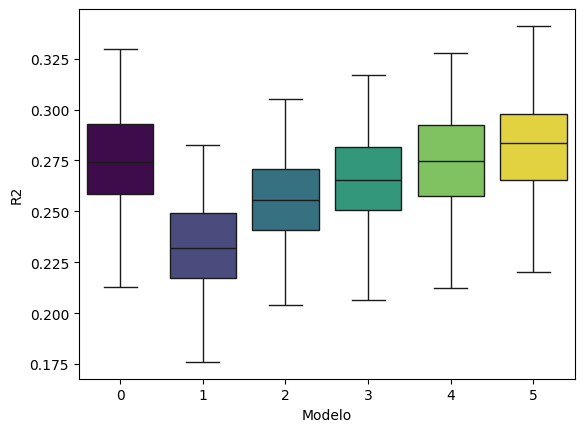

In [68]:
plt.clf()
sns.boxplot(x='Modelo',y='R2',data=results_manual,palette='viridis', hue='Modelo', legend=False)
plt.show()

El mejor modelo para predecir la fuga de clientes es aquel que incluye la interacción Antigüedad * FacturaTotal, junto con variables clave como FacturaMes, Contrato, Int_serv, Fact_sinPapel, Soporte Técnico, Seguridad, CopiaSeguridad, Telf_serv, Varias Líneas y Método de Pago, ya que muestra el mayor rendimiento tanto en AUC (0.844) como en R² (0.283). Esto indica que no solo tiene una alta capacidad de clasificación, sino que también explica mejor la variabilidad en la fuga de clientes, lo que lo convierte en la opción más robusta y generalizable para abordar este problema.

In [69]:
list_sfs = [sfs_back,sfs_forw,sfs_20,sfs_10]
list_sfs

list_res = pd.DataFrame(map(lambda x: cross_val_selectVar(x,Fuga_dummy,varObjBin, seed=2022),list_sfs))

results = list_res.T.melt()
results.columns = ['Modelo','R2']
results.head()

Métrica r2: 0.296 (0.025)
Métrica r2: 0.281 (0.024)
Métrica r2: 0.296 (0.024)
Métrica r2: 0.278 (0.023)


,Modelo,R2
0,0,0.263246
1,0,0.322259
2,0,0.269413
3,0,0.311330
4,0,0.317087


<Axes: xlabel='Modelo', ylabel='R2'>

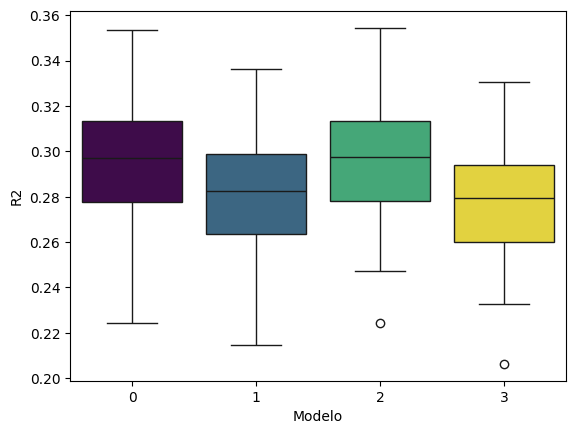

In [70]:
sns.boxplot(x='Modelo',y='R2',data=results,palette='viridis', hue='Modelo', legend=False)

Aplicamos validación cruzada con el objetivo de ver si al agregar interacciones el modelo mejora su capacidad de predecir. Mejorando así su desempeño.
 

In [71]:
list_sfs = [sfs_forw_int_10,selec_feats,selec_feats_int]
list_sfs

list_res = pd.DataFrame(map(lambda x: cross_val_selectVar(x,X_inter,varObjBin, seed=2022),list_sfs))

results_inter = list_res.T.melt()
results_inter.columns = ['Modelo','R2']
results_inter.head()

Métrica r2: 0.261 (0.024)
Métrica r2: 0.297 (0.024)
Métrica r2: 0.290 (0.025)


,Modelo,R2
0,0,0.226378
1,0,0.301093
2,0,0.226434
3,0,0.269667
4,0,0.281554


<Axes: xlabel='Modelo', ylabel='R2'>

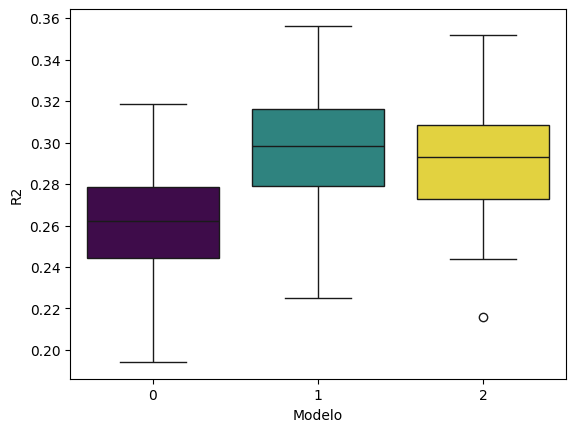

In [72]:
sns.boxplot(x='Modelo',y='R2',data=results_inter,palette='viridis', hue='Modelo', legend=False)

Al realizar la validación cruzada observamos que el Modelo 1 (Lasso sobre variables originales) va a explicar ligeramente mejor la varianza de la variable objetivo, obteniendo un R2 de 0,298. 
 

In [73]:
print(results_manual.groupby(['Modelo']).mean())
print(results.groupby(['Modelo']).mean())
print(results_inter.groupby(['Modelo']).mean())

              R2
Modelo          
0       0.275824
1       0.232218
2       0.255598
3       0.265900
4       0.275543
5       0.283072
              R2
Modelo          
0       0.295953
1       0.280985
2       0.296368
3       0.277843
              R2
Modelo          
0       0.260582
1       0.296973
2       0.290338


# **7. SELECCION DEL MODELO GANADOR**

Despues de realizar los puntos anteriores (Inspección y  depuración de datos, estudio de variable y relaciones, modelo manual, modelado por selección de variables y comparación de modelos), hemos llegado a la conclusión de utilizar como modelo final el **"Modelo 5"**.
 
Hemos decidido el **Modelo 5** ya que sus métricas muestran mejor rendimiento que los otros modelos, muestra una alta precisión, recuperación y puntuación F1, lo que predice de una manera eficaz la pérdida de clientes.
Aparte de ello, muestra una mejor generalización y menor sobreajuste en comparacion con otros modelos evaluados durante el análisis de Método Forward Selection.
 
El **Modelo 5** mostró una precisión alta, lo que significa que la mayoría de sus predicciones fueron correctas. Lo mismo ocurre con el Recall, mostrando niveles elevados, mostrando la capacidad para identificar correctamente a los clientes que están en riesgo de fuga. 

El F1-Score muestra un buen equilibrio entre la precisión y el recall, lo que es importante en problemas de clasificación desbalanceada como la fuga de clientes.
 
Además de estos puntos el **Modelo 5** muestra:
 
1. Evaluación de Ajuste del Modelo:
   Pseudo R^2: el Modelo 5 presenta el mayor valor con 0.2834, lo que significa que el 28.34% de la variabilidad en la fuga de clientes se explica por las variables incluidas en el modelo. Un Pseudo R^2 de este nivel se considera un buen ajuste, lo que sugiere que el modelo es capaz de obtener patrones signficativos de datos.
 
2. Comparación de modelos:
    Al comparar el Modelo 5 con los Modelos 1, 2, 3 y 4, se observa que los valores pseudo R^2 son menores. Siendo el Modelo 1 0.2336, Modelo 2 0.2554, Modelo 3 0.2662 y finalmente el Modelo 4 0.2762.
 
3. Significancia de las Variables:
    El Modelo 5 incluye interacciones entre variables. Por ejemplo, "Antiguedad*FacturaTotal", lo que permite obtener relaciones más complejas. Es importante ya que las interacciones pueden mostrar como diferentes factores combinados afectan la probabilidad de fuga de clientes. Las inclusiones pueden mejorar el ajuste del modelo y aumentar su capacidad predictiva.
 
4. Validación Cruzada:
   Después de usar tecnicas de validación cruzada, el Modelo 5 mostró un rendimiento consistente y superior a diferencia de los otros modelos. Esto indica que no solo se ajuste de manera adecuada a los datos de entrenamiento, sino que también generaliza datos no vistos.
 
5. Métricas de Rendimiento:
    El Modelo 5 mostró un AUC mayor a comparación de los otros modelos. Un AUC alto indica un mejor rendimento la clasificación de los clientes que se irán a los que no se irán.
 
En conclusión, el Modelo 5 ha mostrado ser el mejor modelo a comparación de los otros 4, ya que cuenta con la capacidad de explicar una proporción signficativa de la variabilidad en la fuga de clientes (pseudo R^2 0.2834), las interacciones capturan relaciones complejas, un rendimiento superior en validación cruzada y métricas como el AUC y su interpretabilidad. Gracias a estos factores, estadísticos y prácticos, dan la justificación que el **Modelo 5** es el más adecuado para abordar el problema de fuga de clientes.

# **8. EVALUACION E INTERPRETACION DE VARIABLES**
 

En este apartado se analizarán las variables más influyentes en la fuga de clientes y su impacto, ya sea aumentando o reduciendo su probabilidad. Para ello, se ha utilizado un modelo de regresión logística, transformando sus coeficientes a odds ratios (exp(β)) para facilitar su interpretación.

In [74]:
np.exp(modelo5.params)

Intercept                                0.541831
Contrato[T.One year]                     0.558673
Contrato[T.Two year]                     0.284436
Int_serv[T.Fiber optic]                  1.351159
Int_serv[T.No]                           0.794191
Fact_sinPapel[T.Yes]                     1.691121
Soporte_tecnico[T.Yes]                   0.603662
Seguridad[T.Yes]                         0.601568
CopiaSeguridad[T.Yes]                    0.737412
Telf_serv[T.Yes]                         0.386018
VariasLineas[T.Yes]                      1.280599
MetodoPago[T.Credit card (automatic)]    0.750038
MetodoPago[T.Electronic check]           1.273905
MetodoPago[T.Mailed check]               0.880840
Antiguedad                               0.344411
FacturaTotal                             1.157665
Antiguedad:FacturaTotal                  1.232122
FacturaMes                               1.937793
dtype: float64

*¿Qué variables aumentan la probabilidad de fuga?*
- FacturaMes (1.72). Un mayor gasto mensual está asociado a un 72% más de probabilidad de fuga.
- Fact_sinPapel(T.Yes)(1.65). Recibir factura sin papel incrementa la fuga en un 65%.
- Int_serv(T.Fiber optic)(1.64). Los clientes que tienen contratado el servicio de fibra óptica tienen un 64% más de probabilidad de fugarse.
- VariasLineas(T.Yes)(1.29). Tener varias líneas contratadas incrementa la fuga en un 29%.

*¿Qué variables disminuyen la probabilidad de fuga?*
- Telf_serv(T.Yes)(0.38). Tener servicio telefónico reduce la fuga en un 62%.
- Contrato(.One year)(0.58). Tener un contrato de un año reduce la fuga en un 42%
- Soporte_tecnico(T.Yes)(0.61). Disponer de soporte técnico reduce la fuga en un 39%.
- Seguridad(T.Yes)(0.61). Tener seguridad reduce la fuga en un 39%.
- MetodoPago(T.Credit card (automatic))(0.71). Pagar con tarjeta de crédito automática reduce la fuga en un 29%.

Estos resultados sugieren que la retención de clientes se puede mejorar ofreciendo contratos a largo plazo, brindando soporte técnico y seguridad, y fomentando métodos de pago automáticos.

# 9. PUNTO DE CORTE OPTIMO PARA LA PROBABILIDAD ESTIMADA

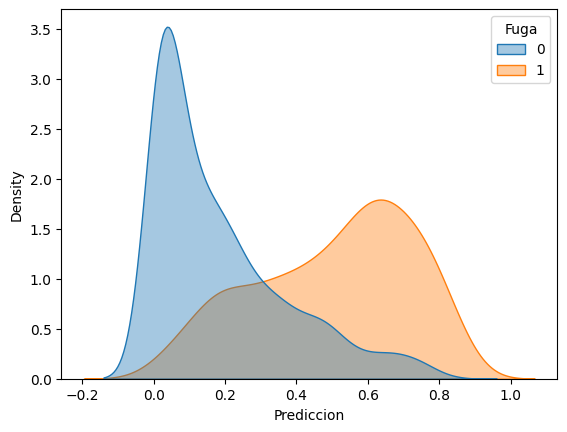

In [75]:
y_pred = modelo5.predict(X_test)

plt.clf()
sns.kdeplot(x=y_pred, hue=y_test, fill=True, common_norm=False, alpha=0.4)
plt.xlabel('Prediccion')
plt.show()

La gráfica representa la distribución de las predicciones del modelo sobre los datos de prueba (X_test), utilizando dos colores para diferenciar las clases: azul para la clase 0 (no fuga) y naranja para la clase 1 (fuga).

Se observa que las predicciones correspondientes a la clase 0 se agrupan principalmente en valores cercanos a 0, mientras que las predicciones de la clase 1 tienden a concentrarse alrededor de 1. Sin embargo, existe una zona de superposición entre ambas distribuciones, lo que sugiere que el modelo experimenta cierta incertidumbre al distinguir entre las dos clases.

La separación entre ambas distribuciones indica que el modelo tiene capacidad para diferenciar entre fuga y no fuga, aunque no con una precisión absoluta. Para optimizar la clasificación, sería útil ajustar la configuración del modelo y evaluar si el umbral de decisión es el más adecuado. También sería importante analizar la distribución de las clases en el conjunto de datos, ya que un posible desequilibrio podría estar influyendo en su rendimiento.
 

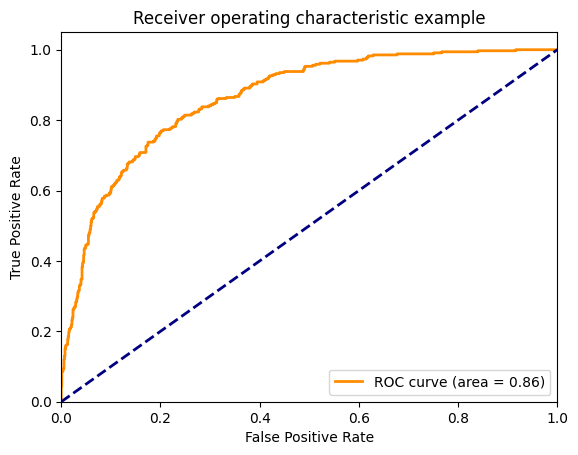

In [76]:
roc_grafico(y_test,y_pred)

In [77]:
corte = cutoff_youden(y_test,y_pred)
corte

np.float64(0.32831435085648686)

La gráfica representa la curva ROC, que mide el desempeño del modelo de clasificación. En el eje X se muestra la tasa de falsos positivos y en el eje Y la de verdaderos positivos.

La línea diagonal indica un clasificador aleatorio, mientras que la curva del modelo (en naranja) está por encima, reflejando su capacidad para distinguir entre clases.

El AUC de 0.86 sugiere un buen rendimiento, aunque con margen de mejora. Un valor de 1.0 indicaría un modelo perfecto, mientras que 0.5 sería equivalente a adivinar al azar.

Se ha determinado un umbral óptimo de 0.32 con el criterio de Youden. Si la predicción supera este valor, se clasifica como positiva; de lo contrario, como negativa. Ajustar este umbral puede mejorar la sensibilidad (detectando más positivos) o la especificidad (reduciendo falsos positivos), según las necesidades del problema.

In [78]:
y_pred = modelo5.predict(X_test)
round(y_pred)

6161    0.0
6198    0.0
801     0.0
1360    0.0
4402    0.0
       ... 
809     0.0
2197    0.0
5383    0.0
1830    0.0
481     1.0
Length: 1271, dtype: float64

El resultado muestra las predicciones del modelo sobre el conjunto de prueba (X_test), donde cada valor representa la clasificación de una observación según el umbral de decisión aplicado.

Se observa que la mayoría de las predicciones son 0.0, indicando que el modelo clasifica la mayoría de los casos como negativos, mientras que pocas observaciones son 1.0. Esto sugiere un posible desbalance en los datos, con una clase predominante.

Este sesgo puede afectar la capacidad del modelo para detectar correctamente la clase positiva. Para evaluar su desempeño real, es clave analizar métricas como precisión, recall y F1-score. Si el desbalance es un problema, se pueden considerar estrategias como ponderación de clases, sobremuestreo o submuestreo para mejorar la detección de la clase minoritaria.

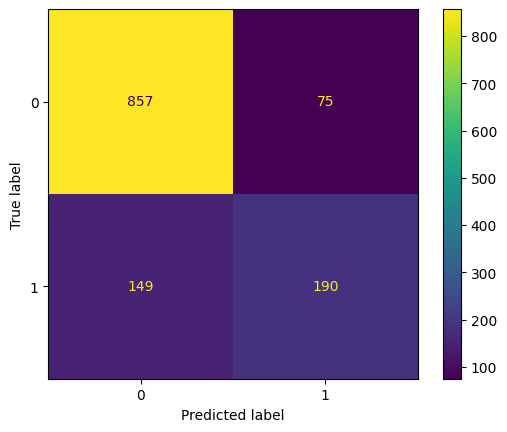

In [79]:
y_pred = modelo5.predict(X_test)
cm = confusion_matrix(y_test, round(y_pred))

cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display
plt.show()

In [80]:
print(metrics.classification_report(y_test,round(y_pred)))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       932
           1       0.72      0.56      0.63       339

    accuracy                           0.82      1271
   macro avg       0.78      0.74      0.76      1271
weighted avg       0.82      0.82      0.82      1271



La matriz de confusión muestra el desempeño del modelo en el conjunto de prueba (X_test), indicando cuántas observaciones fueron clasificadas correctamente o incorrectamente. Se observa que el modelo identifica bien la clase 0, con 861 verdaderos negativos y solo 71 falsos positivos. Sin embargo, tiene dificultades con la clase 1, generando 149 falsos negativos y logrando solo 190 verdaderos positivos.

Las métricas reflejan esta diferencia en el rendimiento. La precisión y recall de la clase 0 son altos (85% y 92%, respectivamente), mientras que en la clase 1, la precisión es aceptable (73%), pero el recall es bajo (56%), lo que indica que el modelo no detecta muchos casos positivos. El F1-score es de 0.89 para la clase 0 y 0.63 para la clase 1, con una exactitud global del 83%.

Aunque el modelo tiene un buen desempeño general, favorece la clase mayoritaria. Para mejorar la detección de la clase 1, se podría considerar algún ajuste, como modificar el umbral de decisión.

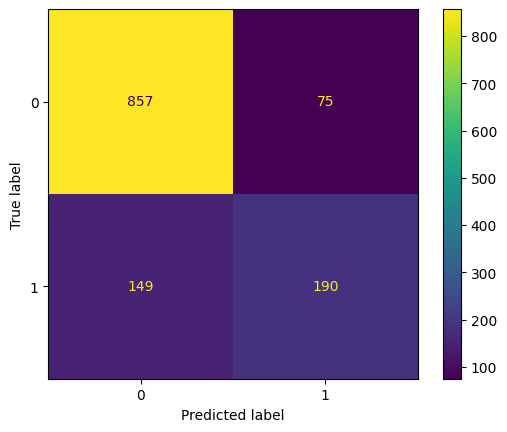

In [81]:
ConfusionMatrixDisplay(cm).plot()

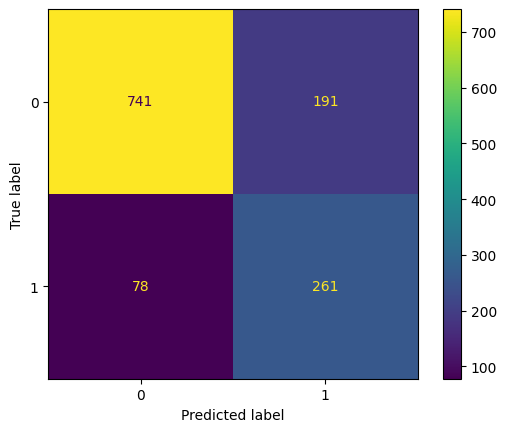

In [82]:
y_pred = modelo5.predict(X_test)
y_clas =  y_pred.map(lambda x: 1 if x > 0.3246447859179493 else 0)

cm = confusion_matrix(y_test, y_clas)

cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display
plt.show(cm_display)

In [83]:
print(metrics.classification_report(y_test,y_clas))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       932
           1       0.58      0.77      0.66       339

    accuracy                           0.79      1271
   macro avg       0.74      0.78      0.75      1271
weighted avg       0.82      0.79      0.80      1271



### Análisis de la matriz de confusión
Los verdaderos negativos (745) corresponden a casos de la clase 0 correctamente clasificados, mientras que los falsos positivos (187) son casos de la clase 0 clasificados erróneamente como 1. Los falsos negativos (80) son casos de la clase 1 mal clasificados como 0, y los verdaderos positivos (259) son casos de la clase 1 correctamente identificados.

El modelo tiene un mejor desempeño en la clasificación de la clase 0, ya que presenta más falsos positivos que falsos negativos, lo que sugiere un sesgo hacia la clase mayoritaria.

En cuanto a las métricas, la precisión para la clase 0 es del 90%, mientras que su recall es del 80%, indicando que identifica bien los casos de esta clase. Por otro lado, la precisión para la clase 1 es más baja, con un 58%, pero el recall es del 76%, lo que muestra una mejora en la detección de los casos de esta clase.

La exactitud global del modelo es del 79%, lo que indica un rendimiento aceptable, aunque todavía hay oportunidades de mejora, especialmente en la precisión de la clase 1.
 

# 10. PREDICCIÓN PARA LOS DATOS DEL TEST

Tras la preparación de los datos del Test, es decir de estandarizar las variables de tal forma que normalizado los datos estos tuvieran la misma escala y la posterior combinación con las las variables numéricas pudimos reconstruis el dataset. Posteriormente generamos la predicción del modelo y así obtener las probabilidades de fuga de cada cliente para estudiar el porcentaje de abadono del servicio.

En la fase de evaluación previa se calculó el punto de corte óptimo que nos permitiría identificar que clientes clasificacmos como Fuga (1) y No Fuga (0).

Finalmente, obtenemos la proporción de de clientes que éstan en riesgo de abandonar el sevicio según el modelo, es decir un 36% de resutlado final.
 
Gracias a este proceso, contamos con una prediccion de fuga basada en datos históricos y un modelo optimizado que junto a la aplicación del punto de corte nos permitió mejorar la precisión del modelo.
 

In [87]:
df_pred = pd.read_csv('FugaClientes_Test.csv')

scaler = StandardScaler()
X_numericas_scaled = scaler.fit_transform(df_pred[vars_numericas])

X_numericas_scaled = pd.DataFrame(X_numericas_scaled, columns=vars_numericas, index=df_pred.index)

df_pred = pd.concat([X_numericas_scaled, df_pred[vars_categoricas]], axis=1)
print(df_pred.head())

   Antiguedad  FacturaMes  FacturaTotal          ID  Genero  Mayor65 Conyuge  \
0   -0.528969    0.804464     -0.237498  4183-MYFRB  Female        0      No   
1   -1.339424   -0.857853     -1.018629  8779-QRDMV    Male        1      No   
2   -0.893674   -1.512555     -0.948967  1680-VDCWW    Male        0     Yes   
3    1.537692    1.129341      2.071214  6234-RAAPL  Female        0     Yes   
4   -0.691060   -1.481221     -0.856426  9867-JCZSP  Female        0     Yes   

  PersCargo Telf_serv VariasLineas     Int_serv Seguridad CopiaSeguridad  \
0        No       Yes           No  Fiber optic        No            Yes   
1        No        No           No          DSL        No             No   
2        No       Yes           No           No        No             No   
3       Yes       Yes          Yes  Fiber optic       Yes            Yes   
4       Yes       Yes           No           No        No             No   

  Antivirus_disp Soporte_tecnico TV_streaming Peliculas       

In [88]:
y_pred = modelo5.predict(df_pred)
y_clas =  y_pred.map(lambda x: 1 if x > 0.3246447859179493 else 0).rename('Prediccion Fuga')
print(y_clas.value_counts(normalize=True))

Prediccion Fuga
0    0.63913
1    0.36087
Name: proportion, dtype: float64


# **11. CONSTRUCCION ARCHIVO: PrediccionFinal_equipo_xonas**

In [89]:
final_dataframe = pd.concat([df_pred,y_clas],axis=1)

final_dataframe = final_dataframe[['ID', 'Prediccion Fuga']]
final_dataframe.to_csv('PrediccionFinal_equipo_xonas.csv')